<table class="table table-bordered">
    <tr>
        <th style="text-align:center; width:25%"><img src='https://www.np.edu.sg/PublishingImages/Pages/default/odp/ICT.jpg' style="width: 250px; height: 125px; "></th>
        <th style="text-align:center;"><h1>Deep Learning</h1><h2>Assignment 2  (Problem 2) - Character Generator Model (Individual)</h2><h3>AY2022/23 Semester</h3></th>
    </tr>
</table>

In [1]:
# Import the Required Packages
import numpy as np
import random
import sys
import string
import re
import pandas as pd
import os
import nltk
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense, Dropout, LSTM, GRU, Flatten, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
from googletrans import Translator

%matplotlib inline

## Step 1 – Data Loading and Processing

### 1.1 Data Loading

In [2]:
text = open('C:/Users/kc/Desktop/YEAR 2 SEM 1/DL/Assignment 2/Harry_Potter_Book1.txt', 'rb').read().decode(encoding='utf-8')
print('Corpus length:', len(text))

Corpus length: 474429


In [3]:
print(text[:1000])

/ 




THE BOY WHO LIVED 

Mr. and Mrs. Dursley, of number four, Privet Drive, 
were proud to say that they were perfectly normal, 
thank you very much. They were the last people you’d 
expect to be involved in anything strange or 
mysterious, because they just didn’t hold with such 
nonsense. 

Mr. Dursley was the director of a firm called 
Grunnings, which made drills. He was a big, beefy 
man with hardly any neck, although he did have a 
very large mustache. Mrs. Dursley was thin and 
blonde and had nearly twice the usual amount of 
neck, which came in very useful as she spent so 
much of her time craning over garden fences, spying 
on the neighbors. The Dursley s had a small son 
called Dudley and in their opinion there was no finer 
boy anywhere. 

The Dursleys had everything they wanted, but they 
also had a secret, and their greatest fear was that 
somebody would discover it. They didn’t think they 
could bear it if anyone found out about the Potters. 
Mrs. Potter was Mrs. Dursl

### 1.2 Data Processing


In [4]:
def clean_text(text):
    punctuation = ['!', ',', '.', ':', ';', '?', '-', "'",' ']
    letters='abcdefghijklmnopqrstuvwxyz'
    cleansed_corpus = ""
    # Enter your code here:
    for i in text:
        if i in punctuation or i in letters:
            cleansed_corpus += i
    return cleansed_corpus

In [5]:
text = clean_text(text.lower())
text[:1000]

' the boy who lived mr. and mrs. dursley, of number four, privet drive, were proud to say that they were perfectly normal, thank you very much. they were the last people youd expect to be involved in anything strange or mysterious, because they just didnt hold with such nonsense. mr. dursley was the director of a firm called grunnings, which made drills. he was a big, beefy man with hardly any neck, although he did have a very large mustache. mrs. dursley was thin and blonde and had nearly twice the usual amount of neck, which came in very useful as she spent so much of her time craning over garden fences, spying on the neighbors. the dursley s had a small son called dudley and in their opinion there was no finer boy anywhere. the dursleys had everything they wanted, but they also had a secret, and their greatest fear was that somebody would discover it. they didnt think they could bear it if anyone found out about the potters. mrs. potter was mrs. dursleys sister, but they hadnt page 

In [6]:
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

35 unique characters


In [7]:
# Window size (length of each sequence)
maxlen = 60

# We sample a new sequence every `step` characters
step = 3

# This holds our extracted sequences
sentences = []

# This holds the targets (the follow-up characters)
next_chars = []

for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('Number of sequences:', len(sentences))
print('sentences[0]: ',sentences[0])
print('next_chars[0]: ',next_chars[0])
print('\n')
print('sentences[1]: ',sentences[1])
print('next_chars[1]: ',next_chars[1])

# List of unique characters in the corpus
chars = sorted(list(set(text)))
print('Unique characters:', len(chars))
print(chars)
# Dictionary mapping unique characters to their index in `chars`
char_indices = dict((char, chars.index(char)) for char in chars)

Number of sequences: 149603
sentences[0]:   the boy who lived mr. and mrs. dursley, of number four, pri
next_chars[0]:  v


sentences[1]:  e boy who lived mr. and mrs. dursley, of number four, privet
next_chars[1]:   
Unique characters: 35
[' ', '!', "'", ',', '-', '.', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [8]:
print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=int)
y = np.zeros((len(sentences), len(chars)), dtype=int)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1
print('len(x): ',len(x))
print('x[0]: ',x[0])
print('len(y): ',len(y))
print('y[0]: ',y[0])

Vectorization...
len(x):  149603
x[0]:  [[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
len(y):  149603
y[0]:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]


In [9]:
x.shape

(149603, 60, 35)

In [10]:
y.shape

(149603, 35)

## Step 2 – Develop Character Generator Model

In [11]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature # take a log function and then divided by temperature
    exp_preds = np.exp(preds) # take a exp function
    preds = exp_preds / np.sum(exp_preds) # normalize to 1
    probas = np.random.multinomial(1, preds, 1) # roll a dice based on the probability distribution in preds
    return np.argmax(probas) #return to the selected "next character"

## 1. LSTM Models

### Step 1: Determine Optimal Weights

#### LSTM Model 1 (Baseline LSTM Model) - 1 LSTM layer with 8 recurrent units

In [49]:
model = keras.models.Sequential()
model.add(layers.LSTM(8, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 8)                 1408      
                                                                 
 dense_9 (Dense)             (None, 35)                315       
                                                                 
Total params: 1,723
Trainable params: 1,723
Non-trainable params: 0
_________________________________________________________________


In [50]:
optimizer = optimizers.RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [51]:
history = model.fit(x, y,
          batch_size=128,
          epochs=30, validation_split=0.2)

    # Select a text seed at random
start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text + '"')
   
    
for temperature in [0.2, 0.5, 1.0, 1.2]:
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

        # We generate 400 characters
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = model.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

        

Epoch 1/30
936/936 [==============================] - 31s 29ms/step - loss: 2.4471 - acc: 0.2955 - val_loss: 2.2863 - val_acc: 0.3321
Epoch 2/30
936/936 [==============================] - 27s 29ms/step - loss: 2.2309 - acc: 0.3502 - val_loss: 2.2278 - val_acc: 0.3523
Epoch 3/30
936/936 [==============================] - 26s 28ms/step - loss: 2.1742 - acc: 0.3650 - val_loss: 2.1831 - val_acc: 0.3660
Epoch 4/30
936/936 [==============================] - 26s 28ms/step - loss: 2.1372 - acc: 0.3748 - val_loss: 2.1544 - val_acc: 0.3774
Epoch 5/30
936/936 [==============================] - 26s 28ms/step - loss: 2.1147 - acc: 0.3841 - val_loss: 2.1323 - val_acc: 0.3813
Epoch 6/30
936/936 [==============================] - 27s 29ms/step - loss: 2.1008 - acc: 0.3898 - val_loss: 2.1224 - val_acc: 0.3840
Epoch 7/30
936/936 [==============================] - 26s 27ms/step - loss: 2.0905 - acc: 0.3938 - val_loss: 2.1072 - val_acc: 0.3942
Epoch 8/30
936/936 [==============================] - 27s 28ms

C:\Users\kc\AppData\Local\Temp\ipykernel_21400\291334795.py:3: RuntimeWarning: divide by zero encountered in log
  preds = np.log(preds) / temperature # take a log function and then divided by temperature


e sae land the poont wad hirne the the beher potter the and was he the the sorale hrun
------ temperature: 1.0
irne the the beher potter the and was he the the sorale hruncwan whes. fis gusly starder ave bitht art taver, gresow; marld bave clou but, a as shuve sor uts rodin then! it lever do hin wand ele, gofct as mor rorce rare towlented  his noid tik on fear woull to ferind ilver .. nor mren milded. oul was duted a whead.  in onprifass, dreld the at tou rut, aml ewe anp ain sport tull hard thaen! gowt det du te seigh corleytuncor pheleriedow yoad ly it, sherpook,
------ temperature: 1.2
t du te seigh corleytuncor pheleriedow yoad ly it, sherpook, stlrin! in ther. his barge opcagf gagl, thent at thing mrosooni, jules warched nat soner him thed wion merile. chitlerind dibent. whe men harromfer weomeyele, sunw rowl. u wie naithen was roboun rofedsovad lolaels thnmep you u fi fereners hadefale  vour, - foof cune rumlu ye pavin pvisro.. ane wacamt bre panch on  inder fill. .oy aw it, here

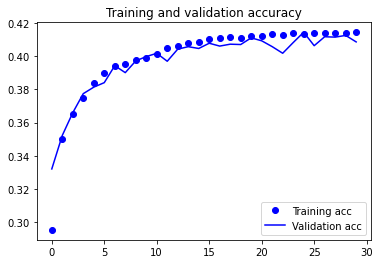

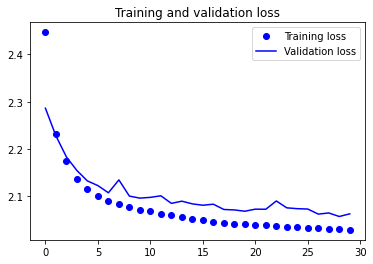

In [52]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### LSTM Model 2 - 1 LSTM layer with 16 recurrent units

In [53]:
model = keras.models.Sequential()
model.add(layers.LSTM(16, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 16)                3328      
                                                                 
 dense_10 (Dense)            (None, 35)                595       
                                                                 
Total params: 3,923
Trainable params: 3,923
Non-trainable params: 0
_________________________________________________________________


In [54]:
optimizer = optimizers.RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [55]:
history = model.fit(x, y,
          batch_size=128,
          epochs=30, validation_split=0.2)

    
    # Select a text seed at random
start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text + '"')
   
    
for temperature in [0.2, 0.5, 1.0, 1.2]:
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

        # We generate 400 characters
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = model.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

Epoch 1/30
936/936 [==============================] - 30s 30ms/step - loss: 2.3136 - acc: 0.3283 - val_loss: 2.1400 - val_acc: 0.3824
Epoch 2/30
936/936 [==============================] - 29s 31ms/step - loss: 2.0382 - acc: 0.4052 - val_loss: 2.0145 - val_acc: 0.4107
Epoch 3/30
936/936 [==============================] - 28s 30ms/step - loss: 1.9611 - acc: 0.4265 - val_loss: 1.9889 - val_acc: 0.4153
Epoch 4/30
936/936 [==============================] - 29s 30ms/step - loss: 1.9185 - acc: 0.4381 - val_loss: 1.9431 - val_acc: 0.4339
Epoch 5/30
936/936 [==============================] - 30s 32ms/step - loss: 1.8867 - acc: 0.4475 - val_loss: 1.9184 - val_acc: 0.4438
Epoch 6/30
936/936 [==============================] - 28s 30ms/step - loss: 1.8649 - acc: 0.4537 - val_loss: 1.8825 - val_acc: 0.4521
Epoch 7/30
936/936 [==============================] - 29s 30ms/step - loss: 1.8491 - acc: 0.4577 - val_loss: 1.8750 - val_acc: 0.4535
Epoch 8/30
936/936 [==============================] - 28s 30ms

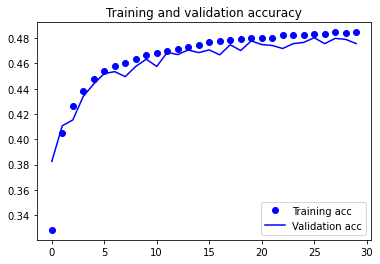

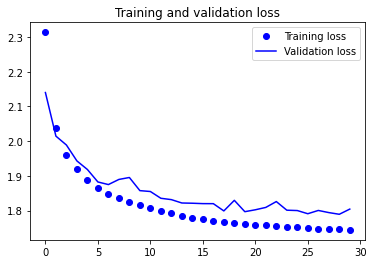

In [56]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### LSTM Model 3 - 1 LSTM layer with 32 recurrent units

In [57]:
model = keras.models.Sequential()
model.add(layers.LSTM(32, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 32)                8704      
                                                                 
 dense_11 (Dense)            (None, 35)                1155      
                                                                 
Total params: 9,859
Trainable params: 9,859
Non-trainable params: 0
_________________________________________________________________


In [58]:
optimizer = optimizers.RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [59]:
history = model.fit(x, y,
          batch_size=128,
          epochs=30, validation_split=0.2)

    
    # Select a text seed at random
start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text + '"')
   
    
for temperature in [0.2, 0.5, 1.0, 1.2]:
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

        # We generate 400 characters
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = model.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

Epoch 1/30
936/936 [==============================] - 42s 42ms/step - loss: 2.1573 - acc: 0.3727 - val_loss: 1.9448 - val_acc: 0.4341
Epoch 2/30
936/936 [==============================] - 38s 40ms/step - loss: 1.8264 - acc: 0.4636 - val_loss: 1.8069 - val_acc: 0.4678
Epoch 3/30
936/936 [==============================] - 38s 41ms/step - loss: 1.7307 - acc: 0.4871 - val_loss: 1.7420 - val_acc: 0.4908
Epoch 4/30
936/936 [==============================] - 37s 40ms/step - loss: 1.6786 - acc: 0.5015 - val_loss: 1.7158 - val_acc: 0.4978
Epoch 5/30
936/936 [==============================] - 38s 41ms/step - loss: 1.6440 - acc: 0.5106 - val_loss: 1.6889 - val_acc: 0.5074
Epoch 6/30
936/936 [==============================] - 41s 44ms/step - loss: 1.6191 - acc: 0.5176 - val_loss: 1.6721 - val_acc: 0.5081
Epoch 7/30
936/936 [==============================] - 38s 40ms/step - loss: 1.6008 - acc: 0.5209 - val_loss: 1.6621 - val_acc: 0.5111
Epoch 8/30
936/936 [==============================] - 38s 40ms

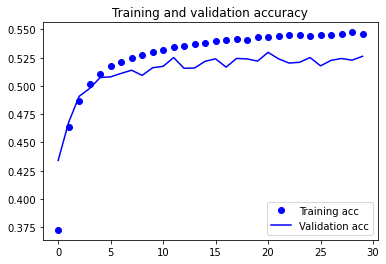

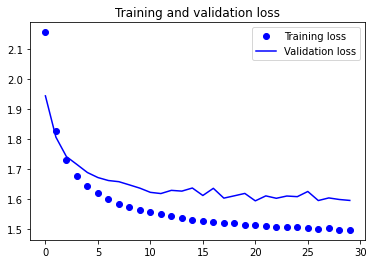

In [60]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### LSTM Model 4 - 1 LSTM layer with 64 recurrent units

In [61]:
model = keras.models.Sequential()
model.add(layers.LSTM(64, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 64)                25600     
                                                                 
 dense_12 (Dense)            (None, 35)                2275      
                                                                 
Total params: 27,875
Trainable params: 27,875
Non-trainable params: 0
_________________________________________________________________


In [62]:
optimizer = optimizers.RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [63]:
history = model.fit(x, y,
          batch_size=128,
          epochs=30, validation_split=0.2)


    # Select a text seed at random
start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text + '"')
   
    
for temperature in [0.2, 0.5, 1.0, 1.2]:
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

        # We generate 400 characters
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = model.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

Epoch 1/30
936/936 [==============================] - 113s 118ms/step - loss: 2.0357 - acc: 0.4063 - val_loss: 1.8331 - val_acc: 0.4590
Epoch 2/30
936/936 [==============================] - 110s 117ms/step - loss: 1.6689 - acc: 0.5018 - val_loss: 1.6896 - val_acc: 0.4880
Epoch 3/30
936/936 [==============================] - 114s 122ms/step - loss: 1.5592 - acc: 0.5292 - val_loss: 1.6090 - val_acc: 0.5205
Epoch 4/30
936/936 [==============================] - 115s 123ms/step - loss: 1.5014 - acc: 0.5433 - val_loss: 1.5774 - val_acc: 0.5330
Epoch 5/30
936/936 [==============================] - 112s 120ms/step - loss: 1.4626 - acc: 0.5551 - val_loss: 1.5712 - val_acc: 0.5305
Epoch 6/30
936/936 [==============================] - 110s 118ms/step - loss: 1.4352 - acc: 0.5624 - val_loss: 1.5569 - val_acc: 0.5360
Epoch 7/30
936/936 [==============================] - 117s 125ms/step - loss: 1.4163 - acc: 0.5674 - val_loss: 1.5444 - val_acc: 0.5397
Epoch 8/30
936/936 [============================

C:\Users\kc\AppData\Local\Temp\ipykernel_21400\291334795.py:3: RuntimeWarning: divide by zero encountered in log
  preds = np.log(preds) / temperature # take a log function and then divided by temperature


ot of he had have with the playfies wand and got the raggh were beak on the could for what they were a 
------ temperature: 1.0
d got the raggh were beak on the could for what they were a sway shoots: silingrelffairs at the send of plotting to this, wormilin was. professor alyen page   harry potter and the philosophers stone - j.k. rowling got best aim with he myaded they were which watched out, hagrid pleak. theyll countenget some, petunia of harry might so, snape was uncrie theyeres. dudley and the time page   hared the philosophers stone - j.k. rowling all the good cleaned was, 
------ temperature: 1.2
philosophers stone - j.k. rowling all the good cleaned was, thinky. harry while  waited  all, as they aut what so tic lay alread. hagrid could his t-watch, she wanded to alyeard, was should yeh extun if mind to liod, eiven here looked. peewed going. too. i unluge, was imported a chide a pladien for up. he slack his nosted was shasse got if - crentied in the quicidory you, said harrys 

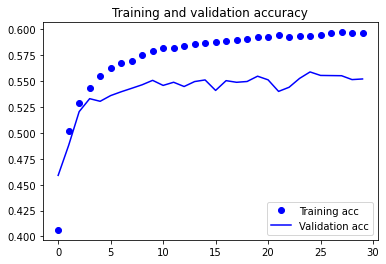

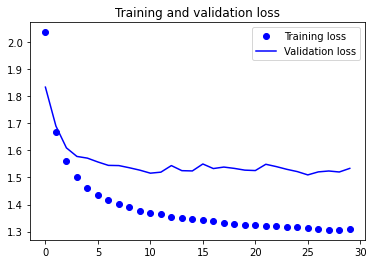

In [64]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### LSTM Model 5 - 1 LSTM layer with 128 recurrent units

In [25]:
model = keras.models.Sequential()
model.add(layers.LSTM(128, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               83968     
                                                                 
 dense_3 (Dense)             (None, 35)                4515      
                                                                 
Total params: 88,483
Trainable params: 88,483
Non-trainable params: 0
_________________________________________________________________


In [26]:
optimizer = optimizers.RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [27]:
history = model.fit(x, y,
          batch_size=128,
          epochs=20, validation_split=0.2)
    
    # Select a text seed at random
start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text + '"')
   
    
for temperature in [0.2, 0.5, 1.0, 1.2]:
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

        # We generate 400 characters
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = model.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

Epoch 1/20
936/936 [==============================] - 120s 126ms/step - loss: 1.9278 - acc: 0.4347 - val_loss: 1.6613 - val_acc: 0.5052
Epoch 2/20
936/936 [==============================] - 112s 120ms/step - loss: 1.5252 - acc: 0.5385 - val_loss: 1.5616 - val_acc: 0.5287
Epoch 3/20
936/936 [==============================] - 109s 117ms/step - loss: 1.4177 - acc: 0.5668 - val_loss: 1.4977 - val_acc: 0.5555
Epoch 4/20
936/936 [==============================] - 113s 121ms/step - loss: 1.3579 - acc: 0.5840 - val_loss: 1.4830 - val_acc: 0.5544
Epoch 5/20
936/936 [==============================] - 112s 120ms/step - loss: 1.3177 - acc: 0.5942 - val_loss: 1.4618 - val_acc: 0.5610
Epoch 6/20
936/936 [==============================] - 105s 112ms/step - loss: 1.2886 - acc: 0.6018 - val_loss: 1.4569 - val_acc: 0.5660
Epoch 7/20
936/936 [==============================] - 109s 117ms/step - loss: 1.2652 - acc: 0.6082 - val_loss: 1.4500 - val_acc: 0.5708
Epoch 8/20
936/936 [============================

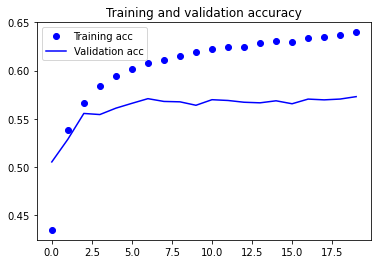

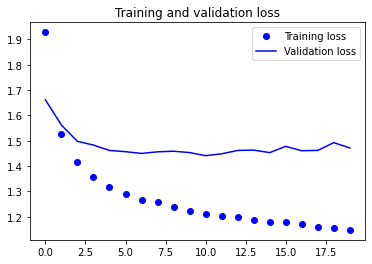

In [28]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### LSTM Model 7 - 2 LSTM layers with 128 recurrent units

In [12]:
model = keras.models.Sequential()
model.add(layers.LSTM(128, return_sequences=True, input_shape=(maxlen, len(chars))))
model.add(layers.LSTM(128, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 128)           83968     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 35)                4515      
                                                                 
Total params: 220,067
Trainable params: 220,067
Non-trainable params: 0
_________________________________________________________________


In [13]:
optimizer = optimizers.RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [14]:
history = model.fit(x, y,
          batch_size=128,
          epochs=20, validation_split=0.2)

    
    # Select a text seed at random
start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text + '"')
   
    
for temperature in [0.2, 0.5, 1.0, 1.2]:
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

        # We generate 400 characters
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = model.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

Epoch 1/20
936/936 [==============================] - 237s 249ms/step - loss: 1.9259 - acc: 0.4328 - val_loss: 1.6381 - val_acc: 0.5126
Epoch 2/20
936/936 [==============================] - 228s 244ms/step - loss: 1.5009 - acc: 0.5428 - val_loss: 1.5373 - val_acc: 0.5382
Epoch 3/20
936/936 [==============================] - 230s 246ms/step - loss: 1.3901 - acc: 0.5734 - val_loss: 1.4789 - val_acc: 0.5616
Epoch 4/20
936/936 [==============================] - 220s 235ms/step - loss: 1.3261 - acc: 0.5908 - val_loss: 1.4430 - val_acc: 0.5658
Epoch 5/20
936/936 [==============================] - 232s 248ms/step - loss: 1.2809 - acc: 0.6033 - val_loss: 1.4723 - val_acc: 0.5645
Epoch 6/20
936/936 [==============================] - 240s 257ms/step - loss: 1.2467 - acc: 0.6121 - val_loss: 1.4369 - val_acc: 0.5706
Epoch 7/20
936/936 [==============================] - 230s 245ms/step - loss: 1.2171 - acc: 0.6191 - val_loss: 1.4562 - val_acc: 0.5719
Epoch 8/20
936/936 [============================

C:\Users\kc\AppData\Local\Temp\ipykernel_60740\291334795.py:3: RuntimeWarning: divide by zero encountered in log
  preds = np.log(preds) / temperature # take a log function and then divided by temperature


 harry, and the potter when they were looking for the bit of his face, but harry potter and the philosophers stone - j.k. rowling the letter them to his back of the street of them and shops of the door and fifty front few a small world of the door and then he was allowed to the door and fifty front going to find them to be in the ground. harry had a sudden
------ temperature: 0.5
t going to find them to be in the ground. harry had a sudden on the motorcth. while a lot of the field the door and fifty back on the bit of a passwer clicker for some door and his name, moved ojushed their silver by his hand. the snake was still dropped out of his face. harry left that they walked out to be been the letter my one of the fat him when i mean, but it was being defling cracked from miniter stuff in the portait and a sit with our toich, mr. ol
------ temperature: 1.0
initer stuff in the portait and a sit with our toich, mr. ollivily ssuff sick. i pidering gold band beech them. right silver,  ... i

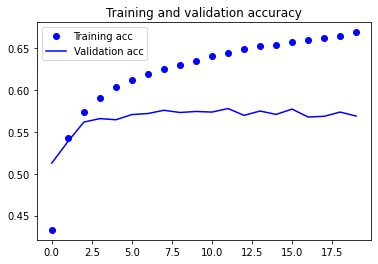

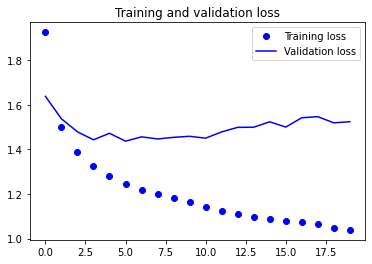

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### LSTM Model 8 - 3 LSTM layers with 128 recurrent units

In [16]:
model = keras.models.Sequential()
model.add(layers.LSTM(128, return_sequences=True, input_shape=(maxlen, len(chars))))
model.add(layers.LSTM(128, return_sequences=True, input_shape=(maxlen, len(chars))))
model.add(layers.LSTM(128, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 128)           83968     
                                                                 
 lstm_3 (LSTM)               (None, 60, 128)           131584    
                                                                 
 lstm_4 (LSTM)               (None, 128)               131584    
                                                                 
 dense_1 (Dense)             (None, 35)                4515      
                                                                 
Total params: 351,651
Trainable params: 351,651
Non-trainable params: 0
_________________________________________________________________


In [17]:
optimizer = optimizers.RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [18]:
history = model.fit(x, y,
          batch_size=128,
          epochs=20, validation_split=0.2)

    
    # Select a text seed at random
start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text + '"')
   
    
for temperature in [0.2, 0.5, 1.0, 1.2]:
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

        # We generate 400 characters
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = model.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

Epoch 1/20
936/936 [==============================] - 421s 444ms/step - loss: 2.2934 - acc: 0.3374 - val_loss: 1.8251 - val_acc: 0.4673
Epoch 2/20
936/936 [==============================] - 399s 426ms/step - loss: 1.6443 - acc: 0.5057 - val_loss: 1.6260 - val_acc: 0.5164
Epoch 3/20
936/936 [==============================] - 399s 426ms/step - loss: 1.5035 - acc: 0.5422 - val_loss: 1.5718 - val_acc: 0.5336
Epoch 4/20
936/936 [==============================] - 419s 447ms/step - loss: 1.4399 - acc: 0.5593 - val_loss: 1.5159 - val_acc: 0.5469
Epoch 5/20
936/936 [==============================] - 407s 435ms/step - loss: 1.3974 - acc: 0.5718 - val_loss: 1.5119 - val_acc: 0.5591
Epoch 6/20
936/936 [==============================] - 382s 409ms/step - loss: 1.3688 - acc: 0.5783 - val_loss: 1.5252 - val_acc: 0.5590
Epoch 7/20
936/936 [==============================] - 390s 416ms/step - loss: 1.3487 - acc: 0.5841 - val_loss: 1.5197 - val_acc: 0.5486
Epoch 8/20
936/936 [============================

C:\Users\kc\AppData\Local\Temp\ipykernel_60740\291334795.py:3: RuntimeWarning: divide by zero encountered in log
  preds = np.log(preds) / temperature # take a log function and then divided by temperature


find the corner and said the tropp of the castless that harry was all the standing and the trofgs of the castless. harry said the thing to the stoor of the boy and the trofgs of the castless. harry was a sharply and saying in the strangled as he was all the sinky  what to his face and he was a sudden watch that the train and said the table of the corner belound the castly 
------ temperature: 0.5
e train and said the table of the corner belound the castly at the hand on the grytvass, and her bed the boys that harry sawed and the other twins of that harry said the bottom at the grofn of the castle to be all. harry shark. it was one  anything the strang to see of peopled at harry, was page   harriar, im water in the hand a with the corning and malfoy took it was make you were dudleys beans that they walled for anym with all you. harry sure the cant w
------ temperature: 1.0
hat they walled for anym with all you. harry sure the cant with was paincut. and a mamor, but the out hagrid, in th

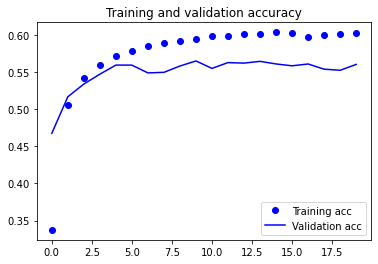

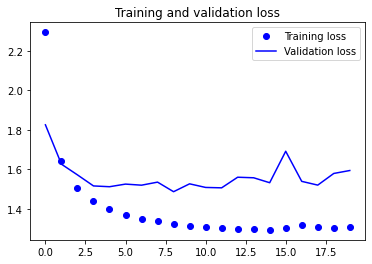

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Step 2. Determine Optimal Batch Size and Optimizer

#### LSTM Model 9 - Batch size 32

In [20]:
model = keras.models.Sequential()
model.add(layers.LSTM(128, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 128)               83968     
                                                                 
 dense_2 (Dense)             (None, 35)                4515      
                                                                 
Total params: 88,483
Trainable params: 88,483
Non-trainable params: 0
_________________________________________________________________


In [21]:
optimizer = optimizers.RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [22]:
history = model.fit(x, y,
          batch_size=32,
          epochs=20, validation_split=0.2)
    
    # Select a text seed at random
start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text + '"')
   
    
for temperature in [0.2, 0.5, 1.0, 1.2]:
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

        # We generate 400 characters
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = model.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

Epoch 1/20
3741/3741 [==============================] - 207s 55ms/step - loss: 1.8237 - acc: 0.4645 - val_loss: 1.6568 - val_acc: 0.5133
Epoch 2/20
3741/3741 [==============================] - 193s 52ms/step - loss: 1.5668 - acc: 0.5334 - val_loss: 1.5732 - val_acc: 0.5369
Epoch 3/20
3741/3741 [==============================] - 192s 51ms/step - loss: 1.5100 - acc: 0.5502 - val_loss: 1.5643 - val_acc: 0.5418
Epoch 4/20
3741/3741 [==============================] - 221s 59ms/step - loss: 1.4745 - acc: 0.5599 - val_loss: 1.5748 - val_acc: 0.5425
Epoch 5/20
3741/3741 [==============================] - 193s 52ms/step - loss: 1.4537 - acc: 0.5651 - val_loss: 1.5335 - val_acc: 0.5493
Epoch 6/20
3741/3741 [==============================] - 179s 48ms/step - loss: 1.4360 - acc: 0.5702 - val_loss: 1.5495 - val_acc: 0.5476
Epoch 7/20
3741/3741 [==============================] - 203s 54ms/step - loss: 1.4295 - acc: 0.5714 - val_loss: 1.5279 - val_acc: 0.5472
Epoch 8/20
3741/3741 [===================

ValueError: pvals < 0, pvals > 1 or pvals contains NaNs

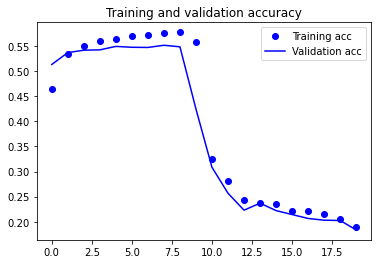

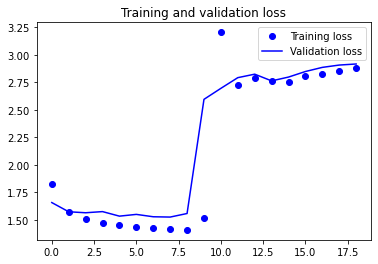

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### LSTM Model 10 - Batch size 64

In [11]:
model = keras.models.Sequential()
model.add(layers.LSTM(128, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               83968     
                                                                 
 dense (Dense)               (None, 35)                4515      
                                                                 
Total params: 88,483
Trainable params: 88,483
Non-trainable params: 0
_________________________________________________________________


In [12]:
optimizer = optimizers.RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [13]:
history = model.fit(x, y,
          batch_size=64,
          epochs=20, validation_split=0.2)

    # Select a text seed at random
start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text + '"')
   
    
for temperature in [0.2, 0.5, 1.0, 1.2]:
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

        # We generate 400 characters
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = model.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

Epoch 1/20
1871/1871 [==============================] - 156s 82ms/step - loss: 1.8447 - acc: 0.4582 - val_loss: 1.6117 - val_acc: 0.5188
Epoch 2/20
1871/1871 [==============================] - 167s 89ms/step - loss: 1.5208 - acc: 0.5409 - val_loss: 1.5282 - val_acc: 0.5424
Epoch 3/20
1871/1871 [==============================] - 147s 78ms/step - loss: 1.4368 - acc: 0.5644 - val_loss: 1.5022 - val_acc: 0.5529
Epoch 4/20
1871/1871 [==============================] - 147s 79ms/step - loss: 1.3896 - acc: 0.5772 - val_loss: 1.4915 - val_acc: 0.5554
Epoch 5/20
1871/1871 [==============================] - 147s 79ms/step - loss: 1.3631 - acc: 0.5844 - val_loss: 1.4700 - val_acc: 0.5657
Epoch 6/20
1871/1871 [==============================] - 151s 81ms/step - loss: 1.3513 - acc: 0.5887 - val_loss: 1.5524 - val_acc: 0.5442
Epoch 7/20
1871/1871 [==============================] - 158s 84ms/step - loss: 1.3461 - acc: 0.5900 - val_loss: 1.4786 - val_acc: 0.5610
Epoch 8/20
1871/1871 [===================

NameError: name 'sample' is not defined

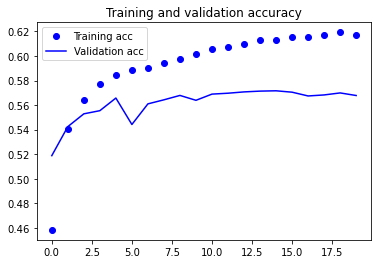

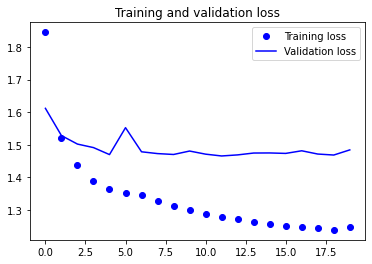

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### LSTM Model 12 - Batch size 256

In [49]:
model = keras.models.Sequential()
model.add(layers.LSTM(128, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 128)               83968     
                                                                 
 dense_4 (Dense)             (None, 35)                4515      
                                                                 
Total params: 88,483
Trainable params: 88,483
Non-trainable params: 0
_________________________________________________________________


In [50]:
optimizer = optimizers.RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [51]:
history = model.fit(x, y,
          batch_size=256,
          epochs=20, validation_split=0.2)

    
    # Select a text seed at random
start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text + '"')
   
    
for temperature in [0.2, 0.5, 1.0, 1.2]:
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

        # We generate 400 characters
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = model.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

Epoch 1/20
468/468 [==============================] - 158s 327ms/step - loss: 2.0345 - acc: 0.4063 - val_loss: 1.7129 - val_acc: 0.4928
Epoch 2/20
468/468 [==============================] - 120s 256ms/step - loss: 1.5698 - acc: 0.5260 - val_loss: 1.5521 - val_acc: 0.5369
Epoch 3/20
468/468 [==============================] - 120s 256ms/step - loss: 1.4374 - acc: 0.5614 - val_loss: 1.4851 - val_acc: 0.5503
Epoch 4/20
468/468 [==============================] - 148s 316ms/step - loss: 1.3606 - acc: 0.5819 - val_loss: 1.4712 - val_acc: 0.5595
Epoch 5/20
468/468 [==============================] - 122s 261ms/step - loss: 1.3088 - acc: 0.5958 - val_loss: 1.4545 - val_acc: 0.5619
Epoch 6/20
468/468 [==============================] - 115s 246ms/step - loss: 1.2698 - acc: 0.6060 - val_loss: 1.4627 - val_acc: 0.5635
Epoch 7/20
468/468 [==============================] - 119s 255ms/step - loss: 1.2397 - acc: 0.6141 - val_loss: 1.4432 - val_acc: 0.5690
Epoch 8/20
468/468 [============================

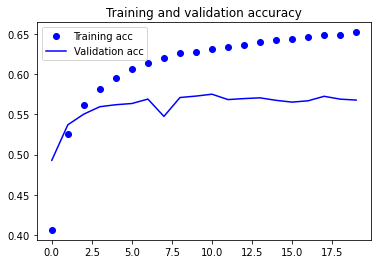

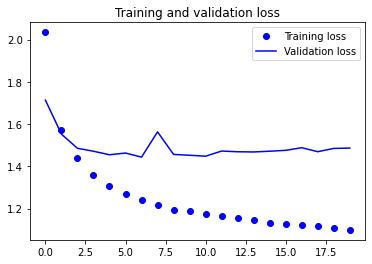

In [52]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### LSTM Model 13 - Batch size 512

In [53]:
model = keras.models.Sequential()
model.add(layers.LSTM(128, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 128)               83968     
                                                                 
 dense_5 (Dense)             (None, 35)                4515      
                                                                 
Total params: 88,483
Trainable params: 88,483
Non-trainable params: 0
_________________________________________________________________


In [54]:
optimizer = optimizers.RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [55]:
history = model.fit(x, y,
          batch_size=512,
          epochs=20, validation_split=0.2)
    
    # Select a text seed at random
start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text + '"')
   
    
for temperature in [0.2, 0.5, 1.0, 1.2]:
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

        # We generate 400 characters
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = model.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

Epoch 1/20
234/234 [==============================] - 137s 578ms/step - loss: 2.2436 - acc: 0.3518 - val_loss: 1.8663 - val_acc: 0.4602
Epoch 2/20
234/234 [==============================] - 147s 626ms/step - loss: 1.7064 - acc: 0.4910 - val_loss: 1.6266 - val_acc: 0.5123
Epoch 3/20
234/234 [==============================] - 138s 590ms/step - loss: 1.5266 - acc: 0.5371 - val_loss: 1.5465 - val_acc: 0.5374
Epoch 4/20
234/234 [==============================] - 135s 576ms/step - loss: 1.4282 - acc: 0.5635 - val_loss: 1.5092 - val_acc: 0.5477
Epoch 5/20
234/234 [==============================] - 137s 586ms/step - loss: 1.3627 - acc: 0.5820 - val_loss: 1.4812 - val_acc: 0.5555
Epoch 6/20
234/234 [==============================] - 130s 554ms/step - loss: 1.3111 - acc: 0.5959 - val_loss: 1.4681 - val_acc: 0.5589
Epoch 7/20
234/234 [==============================] - 129s 551ms/step - loss: 1.2705 - acc: 0.6070 - val_loss: 1.4625 - val_acc: 0.5646
Epoch 8/20
234/234 [============================

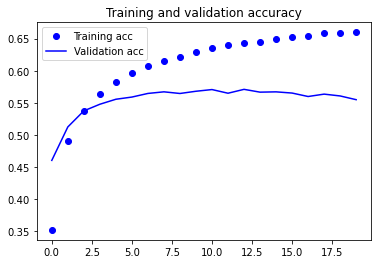

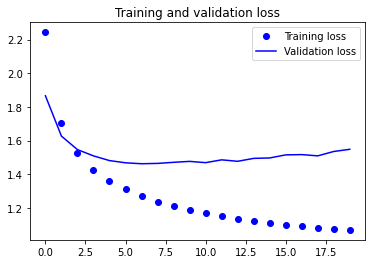

In [56]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### LSTM Model 14 - Adam optimizer

In [65]:
model = keras.models.Sequential()
model.add(layers.LSTM(128, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 128)               83968     
                                                                 
 dense_8 (Dense)             (None, 35)                4515      
                                                                 
Total params: 88,483
Trainable params: 88,483
Non-trainable params: 0
_________________________________________________________________


In [66]:
optimizer = optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [67]:
history = model.fit(x, y,
          batch_size=128,
          epochs=20, validation_split=0.2)


    # Select a text seed at random
start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text + '"')
   
    
for temperature in [0.2, 0.5, 1.0, 1.2]:
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

        # We generate 400 characters
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = model.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

Epoch 1/20
936/936 [==============================] - 241s 256ms/step - loss: 1.9883 - acc: 0.4167 - val_loss: 1.6630 - val_acc: 0.5050
Epoch 2/20
936/936 [==============================] - 240s 256ms/step - loss: 1.5588 - acc: 0.5290 - val_loss: 1.5358 - val_acc: 0.5361
Epoch 3/20
936/936 [==============================] - 241s 258ms/step - loss: 1.4423 - acc: 0.5587 - val_loss: 1.4847 - val_acc: 0.5483
Epoch 4/20
936/936 [==============================] - 238s 254ms/step - loss: 1.3791 - acc: 0.5746 - val_loss: 1.4651 - val_acc: 0.5563
Epoch 5/20
936/936 [==============================] - 235s 251ms/step - loss: 1.3508 - acc: 0.5825 - val_loss: 1.4469 - val_acc: 0.5612
Epoch 6/20
936/936 [==============================] - 254s 271ms/step - loss: 1.3020 - acc: 0.5951 - val_loss: 1.4360 - val_acc: 0.5685
Epoch 7/20
936/936 [==============================] - 228s 244ms/step - loss: 1.2872 - acc: 0.5993 - val_loss: 1.4296 - val_acc: 0.5690
Epoch 8/20
936/936 [============================

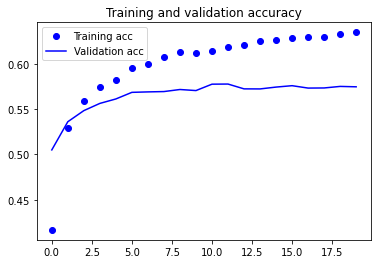

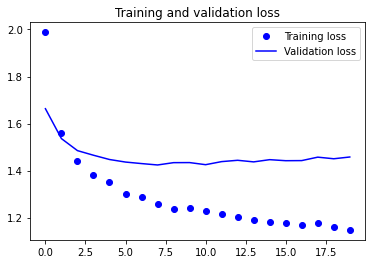

In [68]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### LSTM Model 16 - Rectified Adam Optimizer

In [69]:
model = keras.models.Sequential()
model.add(layers.LSTM(128, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 128)               83968     
                                                                 
 dense_9 (Dense)             (None, 35)                4515      
                                                                 
Total params: 88,483
Trainable params: 88,483
Non-trainable params: 0
_________________________________________________________________


In [70]:
from keras_radam import RAdam
optimizer = RAdam()
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [71]:
history = model.fit(x, y,
          batch_size=128,
          epochs=20, validation_split=0.2)

start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text + '"')
    
    # Select a text seed at random
start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text + '"')
   
    
for temperature in [0.2, 0.5, 1.0, 1.2]:
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

        # We generate 400 characters
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = model.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

Epoch 1/20
936/936 [==============================] - 258s 272ms/step - loss: 2.7730 - acc: 0.2269 - val_loss: 2.4474 - val_acc: 0.3007
Epoch 2/20
936/936 [==============================] - 231s 246ms/step - loss: 2.2785 - acc: 0.3437 - val_loss: 2.2137 - val_acc: 0.3635
Epoch 3/20
936/936 [==============================] - 225s 241ms/step - loss: 2.1047 - acc: 0.3903 - val_loss: 2.0693 - val_acc: 0.4050
Epoch 4/20
936/936 [==============================] - 217s 231ms/step - loss: 1.9794 - acc: 0.4243 - val_loss: 1.9506 - val_acc: 0.4343
Epoch 5/20
936/936 [==============================] - 225s 240ms/step - loss: 1.8764 - acc: 0.4512 - val_loss: 1.8630 - val_acc: 0.4580
Epoch 6/20
936/936 [==============================] - 225s 240ms/step - loss: 1.8071 - acc: 0.4691 - val_loss: 1.7998 - val_acc: 0.4728
Epoch 7/20
936/936 [==============================] - 239s 256ms/step - loss: 1.7375 - acc: 0.4877 - val_loss: 1.7456 - val_acc: 0.4893
Epoch 8/20
936/936 [============================

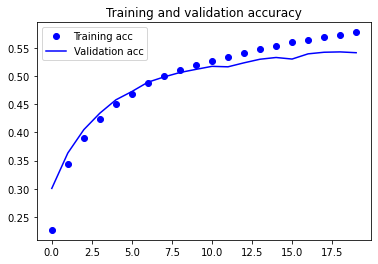

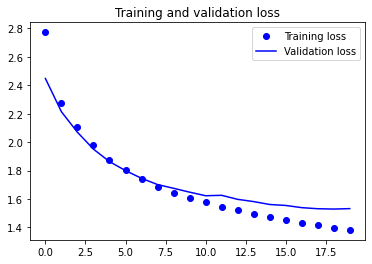

In [72]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Step 3: Reduce Overfitting

#### LSTM Model 18 - Only L2 regularization

In [91]:
model = keras.models.Sequential()
model.add(layers.LSTM(128, recurrent_regularizer = keras.regularizers.l2(0.001), input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 128)               83968     
                                                                 
 dense_15 (Dense)            (None, 35)                4515      
                                                                 
Total params: 88,483
Trainable params: 88,483
Non-trainable params: 0
_________________________________________________________________


In [92]:
optimizer = optimizers.RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [93]:
history = model.fit(x, y,
          batch_size=128,
          epochs=20, validation_split=0.2)

start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text + '"')
    
    # Select a text seed at random
start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text + '"')
   
    
for temperature in [0.2, 0.5, 1.0, 1.2]:
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

        # We generate 400 characters
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = model.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

Epoch 1/20
936/936 [==============================] - 245s 260ms/step - loss: 2.1741 - acc: 0.3873 - val_loss: 2.0807 - val_acc: 0.4311
Epoch 2/20
936/936 [==============================] - 249s 266ms/step - loss: 1.8692 - acc: 0.4754 - val_loss: 2.0167 - val_acc: 0.4572
Epoch 3/20
936/936 [==============================] - 246s 263ms/step - loss: 1.7984 - acc: 0.4947 - val_loss: 1.8944 - val_acc: 0.4748
Epoch 4/20
936/936 [==============================] - 249s 267ms/step - loss: 1.7556 - acc: 0.5062 - val_loss: 1.8270 - val_acc: 0.4996
Epoch 5/20
936/936 [==============================] - 248s 265ms/step - loss: 1.7296 - acc: 0.5140 - val_loss: 1.8143 - val_acc: 0.5026
Epoch 6/20
936/936 [==============================] - 251s 268ms/step - loss: 1.7111 - acc: 0.5184 - val_loss: 1.7442 - val_acc: 0.5146
Epoch 7/20
936/936 [==============================] - 250s 267ms/step - loss: 1.6958 - acc: 0.5222 - val_loss: 1.8213 - val_acc: 0.4990
Epoch 8/20
936/936 [============================

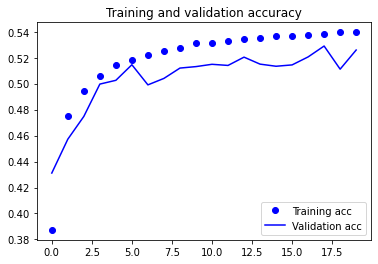

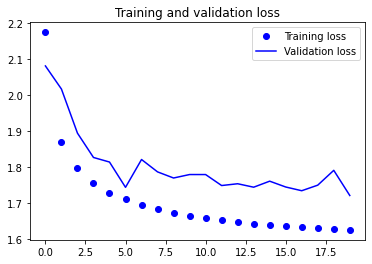

In [94]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### LSTM Model 19 - Only regular dropout

In [95]:
model = keras.models.Sequential()
model.add(layers.LSTM(128, dropout = 0.1, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 128)               83968     
                                                                 
 dense_16 (Dense)            (None, 35)                4515      
                                                                 
Total params: 88,483
Trainable params: 88,483
Non-trainable params: 0
_________________________________________________________________


In [96]:
optimizer = optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [97]:
history = model.fit(x, y,
          batch_size=128,
          epochs=20, validation_split=0.2)

start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text + '"')
    
    # Select a text seed at random
start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text + '"')
   
    
for temperature in [0.2, 0.5, 1.0, 1.2]:
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

        # We generate 400 characters
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = model.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

Epoch 1/20
936/936 [==============================] - 286s 304ms/step - loss: 2.1427 - acc: 0.3745 - val_loss: 1.7433 - val_acc: 0.4819
Epoch 2/20
936/936 [==============================] - 291s 311ms/step - loss: 1.7660 - acc: 0.4721 - val_loss: 1.6005 - val_acc: 0.5212
Epoch 3/20
936/936 [==============================] - 290s 310ms/step - loss: 1.6667 - acc: 0.4989 - val_loss: 1.5487 - val_acc: 0.5368
Epoch 4/20
936/936 [==============================] - 289s 308ms/step - loss: 1.6119 - acc: 0.5098 - val_loss: 1.5118 - val_acc: 0.5426
Epoch 5/20
936/936 [==============================] - 287s 306ms/step - loss: 1.5745 - acc: 0.5204 - val_loss: 1.4795 - val_acc: 0.5517
Epoch 6/20
936/936 [==============================] - 288s 308ms/step - loss: 1.5468 - acc: 0.5298 - val_loss: 1.4726 - val_acc: 0.5536
Epoch 7/20
936/936 [==============================] - 290s 310ms/step - loss: 1.5244 - acc: 0.5342 - val_loss: 1.4624 - val_acc: 0.5599
Epoch 8/20
936/936 [============================

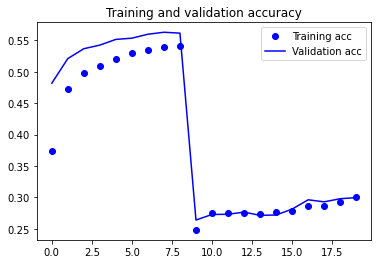

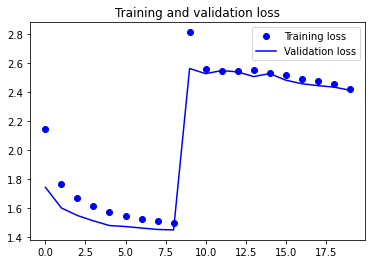

In [98]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### LSTM Model 20 - Only recurrent dropout

In [99]:
model = keras.models.Sequential()
model.add(layers.LSTM(128, recurrent_dropout = 0.1, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 128)               83968     
                                                                 
 dense_17 (Dense)            (None, 35)                4515      
                                                                 
Total params: 88,483
Trainable params: 88,483
Non-trainable params: 0
_________________________________________________________________


In [100]:
optimizer = optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [101]:
history = model.fit(x, y,
          batch_size=128,
          epochs=20, validation_split=0.2)

start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text + '"')
    
    # Select a text seed at random
start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text + '"')
   
    
for temperature in [0.2, 0.5, 1.0, 1.2]:
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

        # We generate 400 characters
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = model.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

Epoch 1/20
936/936 [==============================] - 352s 375ms/step - loss: 1.9651 - acc: 0.4234 - val_loss: 1.6613 - val_acc: 0.5027
Epoch 2/20
936/936 [==============================] - 349s 372ms/step - loss: 1.5831 - acc: 0.5205 - val_loss: 1.5342 - val_acc: 0.5337
Epoch 3/20
936/936 [==============================] - 350s 374ms/step - loss: 1.4875 - acc: 0.5451 - val_loss: 1.4927 - val_acc: 0.5476
Epoch 4/20
936/936 [==============================] - 347s 370ms/step - loss: 1.4292 - acc: 0.5603 - val_loss: 1.4555 - val_acc: 0.5581
Epoch 5/20
936/936 [==============================] - 347s 371ms/step - loss: 1.3972 - acc: 0.5677 - val_loss: 1.4333 - val_acc: 0.5657
Epoch 6/20
936/936 [==============================] - 348s 372ms/step - loss: 1.3710 - acc: 0.5748 - val_loss: 1.4325 - val_acc: 0.5640
Epoch 7/20
936/936 [==============================] - 348s 372ms/step - loss: 1.3626 - acc: 0.5776 - val_loss: 1.4233 - val_acc: 0.5672
Epoch 8/20
936/936 [============================

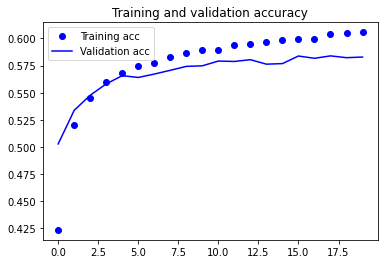

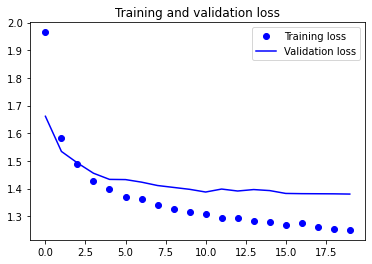

In [102]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### LSTM Model 21 - Recurrent dropout + regular dropout

In [103]:
model = keras.models.Sequential()
model.add(layers.LSTM(128, dropout = 0.1, recurrent_dropout = 0.1, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 128)               83968     
                                                                 
 dense_18 (Dense)            (None, 35)                4515      
                                                                 
Total params: 88,483
Trainable params: 88,483
Non-trainable params: 0
_________________________________________________________________


In [104]:
optimizer = optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [106]:
history = model.fit(x, y,
          batch_size=128,
          epochs=20, validation_split=0.2)

start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text + '"')
    
    # Select a text seed at random
start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text + '"')
   
    
for temperature in [0.2, 0.5, 1.0, 1.2]:
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

        # We generate 400 characters
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = model.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

Epoch 1/20
936/936 [==============================] - 657s 702ms/step - loss: 1.5951 - acc: 0.5168 - val_loss: 1.5392 - val_acc: 0.5323
Epoch 2/20
936/936 [==============================] - 598s 639ms/step - loss: 1.5491 - acc: 0.5268 - val_loss: 1.5014 - val_acc: 0.5445
Epoch 3/20
936/936 [==============================] - 599s 640ms/step - loss: 1.5091 - acc: 0.5371 - val_loss: 1.4761 - val_acc: 0.5533
Epoch 4/20
936/936 [==============================] - 602s 644ms/step - loss: 1.4823 - acc: 0.5438 - val_loss: 1.4588 - val_acc: 0.5547
Epoch 5/20
936/936 [==============================] - 581s 620ms/step - loss: 1.4656 - acc: 0.5474 - val_loss: 1.4447 - val_acc: 0.5583
Epoch 6/20
936/936 [==============================] - 540s 577ms/step - loss: 1.4495 - acc: 0.5519 - val_loss: 1.4392 - val_acc: 0.5612
Epoch 7/20
936/936 [==============================] - 502s 536ms/step - loss: 1.4800 - acc: 0.5445 - val_loss: 1.8062 - val_acc: 0.4607
Epoch 8/20
936/936 [============================

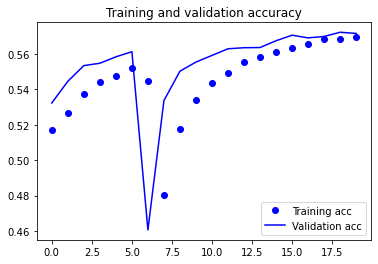

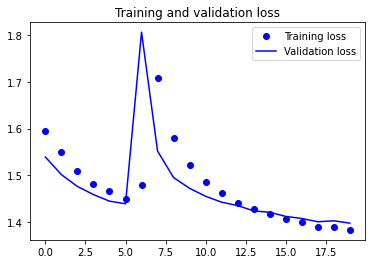

In [107]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### LSTM Model 22 - Recurrent dropout + L2 regularization

In [108]:
model = keras.models.Sequential()
model.add(layers.LSTM(128, recurrent_dropout = 0.1, recurrent_regularizer = keras.regularizers.l2(0.001), 
                      input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 128)               83968     
                                                                 
 dense_19 (Dense)            (None, 35)                4515      
                                                                 
Total params: 88,483
Trainable params: 88,483
Non-trainable params: 0
_________________________________________________________________


In [109]:
optimizer = optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [110]:
history = model.fit(x, y,
          batch_size=128,
          epochs=20, validation_split=0.2)

start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text + '"')
    
    # Select a text seed at random
start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text + '"')
   
    
for temperature in [0.2, 0.5, 1.0, 1.2]:
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

        # We generate 400 characters
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = model.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

Epoch 1/20
936/936 [==============================] - 436s 463ms/step - loss: 2.2113 - acc: 0.3749 - val_loss: 1.9887 - val_acc: 0.4396
Epoch 2/20
936/936 [==============================] - 348s 372ms/step - loss: 1.9100 - acc: 0.4615 - val_loss: 1.8709 - val_acc: 0.4814
Epoch 3/20
936/936 [==============================] - 420s 449ms/step - loss: 1.8168 - acc: 0.4885 - val_loss: 1.8116 - val_acc: 0.4965
Epoch 4/20
936/936 [==============================] - 433s 463ms/step - loss: 1.7725 - acc: 0.5013 - val_loss: 1.7963 - val_acc: 0.4980
Epoch 5/20
936/936 [==============================] - 419s 447ms/step - loss: 1.7420 - acc: 0.5091 - val_loss: 1.7613 - val_acc: 0.5056
Epoch 6/20
936/936 [==============================] - 408s 435ms/step - loss: 1.7171 - acc: 0.5146 - val_loss: 1.7558 - val_acc: 0.5124
Epoch 7/20
936/936 [==============================] - 453s 484ms/step - loss: 1.6951 - acc: 0.5205 - val_loss: 1.7471 - val_acc: 0.5089
Epoch 8/20
936/936 [============================

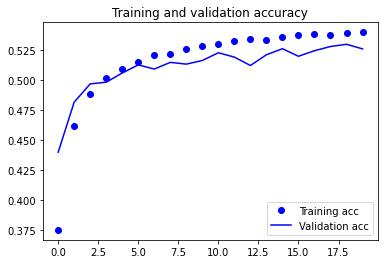

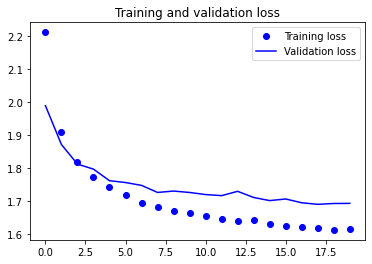

In [111]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### LSTM Model 23  - L2 regularizer + regular dropout

In [112]:
model = keras.models.Sequential()
model.add(layers.LSTM(128, recurrent_regularizer = keras.regularizers.l2(0.001), dropout=0.1, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 128)               83968     
                                                                 
 dense_20 (Dense)            (None, 35)                4515      
                                                                 
Total params: 88,483
Trainable params: 88,483
Non-trainable params: 0
_________________________________________________________________


In [113]:
optimizer = optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [114]:
history = model.fit(x, y,
          batch_size=128,
          epochs=20, validation_split=0.2)

start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text + '"')
    
    # Select a text seed at random
start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text + '"')
   
    
for temperature in [0.2, 0.5, 1.0, 1.2]:
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

        # We generate 400 characters
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = model.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

Epoch 1/20
936/936 [==============================] - 350s 370ms/step - loss: 2.2771 - acc: 0.3568 - val_loss: 2.0002 - val_acc: 0.4402
Epoch 2/20
936/936 [==============================] - 308s 329ms/step - loss: 2.0418 - acc: 0.4244 - val_loss: 1.8894 - val_acc: 0.4691
Epoch 3/20
936/936 [==============================] - 304s 325ms/step - loss: 1.9684 - acc: 0.4454 - val_loss: 1.8336 - val_acc: 0.4874
Epoch 4/20
936/936 [==============================] - 306s 327ms/step - loss: 1.9369 - acc: 0.4540 - val_loss: 1.8083 - val_acc: 0.4956
Epoch 5/20
936/936 [==============================] - 310s 331ms/step - loss: 1.9070 - acc: 0.4604 - val_loss: 1.7841 - val_acc: 0.4974
Epoch 6/20
936/936 [==============================] - 306s 327ms/step - loss: 1.8887 - acc: 0.4656 - val_loss: 1.7682 - val_acc: 0.5004
Epoch 7/20
936/936 [==============================] - 311s 333ms/step - loss: 1.8767 - acc: 0.4687 - val_loss: 1.7476 - val_acc: 0.5091
Epoch 8/20
936/936 [============================

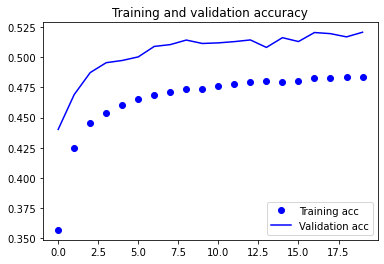

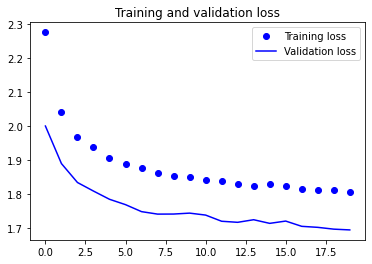

In [115]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### LSTM Model 24 - L2 regularizer + regular dropout + recurrent dropout 

In [116]:
model = keras.models.Sequential()
model.add(layers.LSTM(128, recurrent_regularizer = keras.regularizers.l2(0.001), dropout=0.1, 
                      recurrent_dropout = 0.1, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 128)               83968     
                                                                 
 dense_21 (Dense)            (None, 35)                4515      
                                                                 
Total params: 88,483
Trainable params: 88,483
Non-trainable params: 0
_________________________________________________________________


In [117]:
optimizer = optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [118]:
history = model.fit(x, y,
          batch_size=128,
          epochs=20, validation_split=0.2)

start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text + '"')
    
    # Select a text seed at random
start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text + '"')
   
    
for temperature in [0.2, 0.5, 1.0, 1.2]:
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

        # We generate 400 characters
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = model.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

Epoch 1/20
936/936 [==============================] - 380s 404ms/step - loss: 2.2546 - acc: 0.3638 - val_loss: 2.0198 - val_acc: 0.4315
Epoch 2/20
936/936 [==============================] - 354s 379ms/step - loss: 1.9950 - acc: 0.4397 - val_loss: 1.9111 - val_acc: 0.4664
Epoch 3/20
936/936 [==============================] - 357s 381ms/step - loss: 1.9339 - acc: 0.4589 - val_loss: 1.8537 - val_acc: 0.4795
Epoch 4/20
936/936 [==============================] - 371s 396ms/step - loss: 1.8897 - acc: 0.4690 - val_loss: 1.8453 - val_acc: 0.4909
Epoch 5/20
936/936 [==============================] - 375s 400ms/step - loss: 1.8616 - acc: 0.4753 - val_loss: 1.8160 - val_acc: 0.4936
Epoch 6/20
936/936 [==============================] - 355s 379ms/step - loss: 1.8477 - acc: 0.4787 - val_loss: 1.7994 - val_acc: 0.5002
Epoch 7/20
936/936 [==============================] - 366s 391ms/step - loss: 1.8375 - acc: 0.4837 - val_loss: 1.7856 - val_acc: 0.4982
Epoch 8/20
936/936 [============================

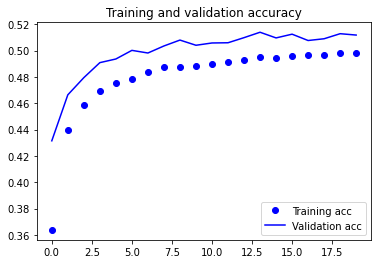

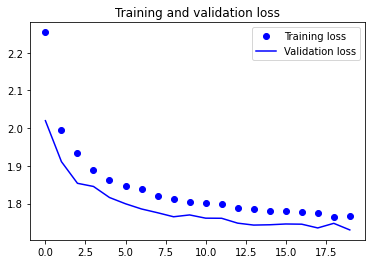

In [119]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Retraining LSTM Model 20 until model stops improving

In [12]:
model = keras.models.Sequential()
model.add(layers.LSTM(128, recurrent_dropout = 0.1, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               83968     
                                                                 
 dense (Dense)               (None, 35)                4515      
                                                                 
Total params: 88,483
Trainable params: 88,483
Non-trainable params: 0
_________________________________________________________________


In [13]:
optimizer = optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [14]:
history = model.fit(x, y, batch_size=128,epochs=100, validation_split=0.2, 
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                                patience=12, restore_best_weights=True)])


    # Select a text seed at random
start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text + '"')
   
    
for temperature in [0.2, 0.5, 1.0, 1.2]:
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

        # We generate 400 characters
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = model.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

Epoch 1/100
936/936 [==============================] - 145s 153ms/step - loss: 2.0003 - acc: 0.4152 - val_loss: 1.6840 - val_acc: 0.4938
Epoch 2/100
936/936 [==============================] - 128s 136ms/step - loss: 1.6085 - acc: 0.5145 - val_loss: 1.5462 - val_acc: 0.5311
Epoch 3/100
936/936 [==============================] - 127s 136ms/step - loss: 1.5006 - acc: 0.5399 - val_loss: 1.4930 - val_acc: 0.5488
Epoch 4/100
936/936 [==============================] - 127s 136ms/step - loss: 1.4417 - acc: 0.5558 - val_loss: 1.4596 - val_acc: 0.5555
Epoch 5/100
936/936 [==============================] - 127s 136ms/step - loss: 1.4039 - acc: 0.5659 - val_loss: 1.4521 - val_acc: 0.5622
Epoch 6/100
936/936 [==============================] - 128s 137ms/step - loss: 1.3893 - acc: 0.5708 - val_loss: 1.4217 - val_acc: 0.5686
Epoch 7/100
936/936 [==============================] - 127s 135ms/step - loss: 1.3547 - acc: 0.5792 - val_loss: 1.4216 - val_acc: 0.5689
Epoch 8/100
936/936 [====================

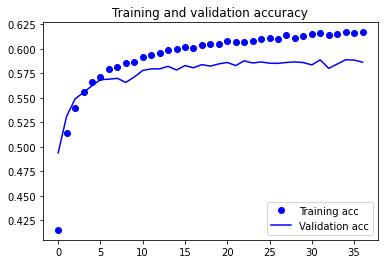

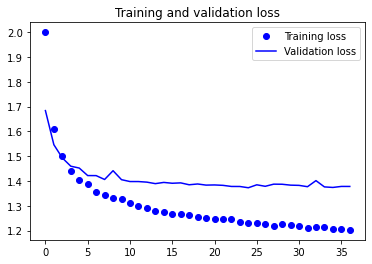

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [16]:
model.save('best_language_model.h5')

## 2. GRU Models

### Step 1. Determine Optimal Weights

#### GRU Model 1 (baseline model) - 1 GRU layer with 8 recurrent units

In [108]:
model = keras.models.Sequential()
model.add(layers.GRU(8, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 8)                 1080      
                                                                 
 dense_22 (Dense)            (None, 35)                315       
                                                                 
Total params: 1,395
Trainable params: 1,395
Non-trainable params: 0
_________________________________________________________________


In [109]:
optimizer = optimizers.RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [110]:
history = model.fit(x, y,
          batch_size=128,
          epochs=20, validation_split=0.2)

start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text + '"')
    
    # Select a text seed at random
start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text + '"')
   
    
for temperature in [0.2, 0.5, 1.0, 1.2]:
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

        # We generate 400 characters
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = model.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

Epoch 1/20
936/936 [==============================] - 45s 46ms/step - loss: 2.3314 - acc: 0.3208 - val_loss: 2.2084 - val_acc: 0.3461
Epoch 2/20
936/936 [==============================] - 36s 39ms/step - loss: 2.1461 - acc: 0.3700 - val_loss: 2.1557 - val_acc: 0.3705
Epoch 3/20
936/936 [==============================] - 31s 34ms/step - loss: 2.1069 - acc: 0.3820 - val_loss: 2.1317 - val_acc: 0.3804
Epoch 4/20
936/936 [==============================] - 31s 33ms/step - loss: 2.0865 - acc: 0.3886 - val_loss: 2.1154 - val_acc: 0.3784
Epoch 5/20
936/936 [==============================] - 31s 33ms/step - loss: 2.0729 - acc: 0.3916 - val_loss: 2.1156 - val_acc: 0.3809
Epoch 6/20
936/936 [==============================] - 29s 31ms/step - loss: 2.0630 - acc: 0.3950 - val_loss: 2.1033 - val_acc: 0.3918
Epoch 7/20
936/936 [==============================] - 30s 32ms/step - loss: 2.0552 - acc: 0.3970 - val_loss: 2.0979 - val_acc: 0.3882
Epoch 8/20
936/936 [==============================] - 29s 31ms

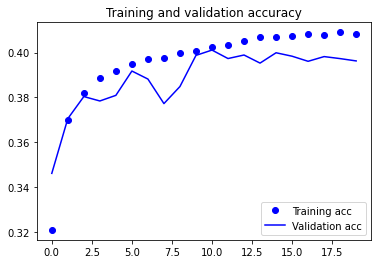

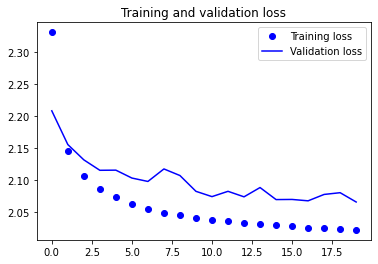

In [111]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### GRU Model 2 - 1 GRU layer with 16 recurrent units

In [112]:
model = keras.models.Sequential()
model.add(layers.GRU(16, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 16)                2544      
                                                                 
 dense_23 (Dense)            (None, 35)                595       
                                                                 
Total params: 3,139
Trainable params: 3,139
Non-trainable params: 0
_________________________________________________________________


In [113]:
optimizer = optimizers.RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [114]:
history = model.fit(x, y,
          batch_size=128,
          epochs=20, validation_split=0.2)

start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text + '"')
    
    # Select a text seed at random
start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text + '"')
   
    
for temperature in [0.2, 0.5, 1.0, 1.2]:
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

        # We generate 400 characters
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = model.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

Epoch 1/20
936/936 [==============================] - 34s 34ms/step - loss: 2.1913 - acc: 0.3584 - val_loss: 2.0590 - val_acc: 0.4021
Epoch 2/20
936/936 [==============================] - 31s 33ms/step - loss: 1.9611 - acc: 0.4254 - val_loss: 1.9530 - val_acc: 0.4335
Epoch 3/20
936/936 [==============================] - 31s 33ms/step - loss: 1.9063 - acc: 0.4423 - val_loss: 1.9498 - val_acc: 0.4326
Epoch 4/20
936/936 [==============================] - 30s 32ms/step - loss: 1.8781 - acc: 0.4512 - val_loss: 1.9078 - val_acc: 0.4447
Epoch 5/20
936/936 [==============================] - 31s 33ms/step - loss: 1.8601 - acc: 0.4567 - val_loss: 1.8965 - val_acc: 0.4528
Epoch 6/20
936/936 [==============================] - 31s 33ms/step - loss: 1.8486 - acc: 0.4598 - val_loss: 1.8849 - val_acc: 0.4569
Epoch 7/20
936/936 [==============================] - 31s 33ms/step - loss: 1.8393 - acc: 0.4617 - val_loss: 1.8786 - val_acc: 0.4552
Epoch 8/20
936/936 [==============================] - 30s 32ms

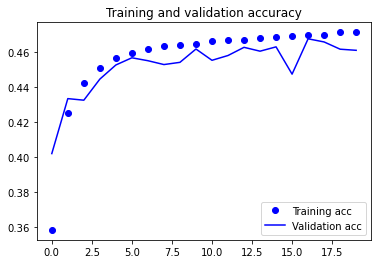

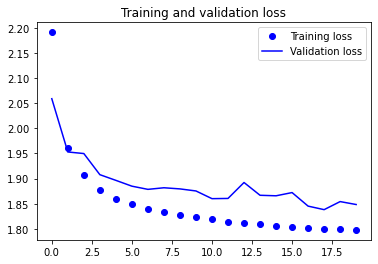

In [115]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### GRU Model 3 - 1 GRU layer with 32 recurrent units

In [116]:
model = keras.models.Sequential()
model.add(layers.GRU(32, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 32)                6624      
                                                                 
 dense_24 (Dense)            (None, 35)                1155      
                                                                 
Total params: 7,779
Trainable params: 7,779
Non-trainable params: 0
_________________________________________________________________


In [117]:
optimizer = optimizers.RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [118]:
history = model.fit(x, y,
          batch_size=128,
          epochs=20, validation_split=0.2)

start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text + '"')
    
    # Select a text seed at random
start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text + '"')
   
    
for temperature in [0.2, 0.5, 1.0, 1.2]:
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

        # We generate 400 characters
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = model.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

Epoch 1/20
936/936 [==============================] - 44s 44ms/step - loss: 2.0561 - acc: 0.4018 - val_loss: 1.9198 - val_acc: 0.4369
Epoch 2/20
936/936 [==============================] - 44s 47ms/step - loss: 1.7908 - acc: 0.4724 - val_loss: 1.8433 - val_acc: 0.4639
Epoch 3/20
936/936 [==============================] - 42s 45ms/step - loss: 1.7201 - acc: 0.4913 - val_loss: 1.7825 - val_acc: 0.4681
Epoch 4/20
936/936 [==============================] - 44s 47ms/step - loss: 1.6832 - acc: 0.5011 - val_loss: 1.7426 - val_acc: 0.4904
Epoch 5/20
936/936 [==============================] - 44s 47ms/step - loss: 1.6586 - acc: 0.5063 - val_loss: 1.7250 - val_acc: 0.4939
Epoch 6/20
936/936 [==============================] - 43s 46ms/step - loss: 1.6407 - acc: 0.5130 - val_loss: 1.7231 - val_acc: 0.4977
Epoch 7/20
936/936 [==============================] - 43s 46ms/step - loss: 1.6294 - acc: 0.5148 - val_loss: 1.7731 - val_acc: 0.4766
Epoch 8/20
936/936 [==============================] - 44s 46ms

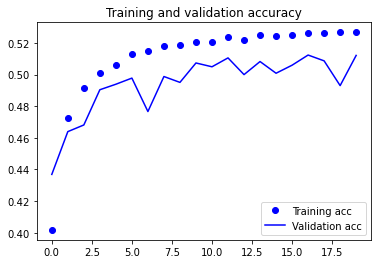

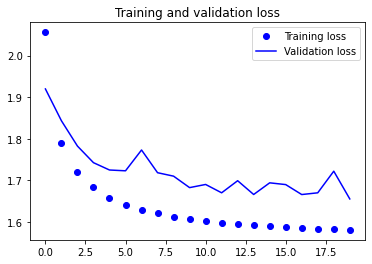

In [119]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### GRU Model 4 - 1 GRU layer with 64 recurrent units

In [13]:
model = keras.models.Sequential()
model.add(layers.GRU(64, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                19392     
                                                                 
 dense (Dense)               (None, 35)                2275      
                                                                 
Total params: 21,667
Trainable params: 21,667
Non-trainable params: 0
_________________________________________________________________


In [14]:
optimizer = optimizers.RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [15]:
history = model.fit(x, y,
          batch_size=128,
          epochs=20, validation_split=0.2)

start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text + '"')
    
    # Select a text seed at random
start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text + '"')
   
    
for temperature in [0.2, 0.5, 1.0, 1.2]:
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

        # We generate 400 characters
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = model.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

Epoch 1/20
936/936 [==============================] - 58s 59ms/step - loss: 1.9476 - acc: 0.4324 - val_loss: 1.8547 - val_acc: 0.4606
Epoch 2/20
936/936 [==============================] - 52s 56ms/step - loss: 1.6567 - acc: 0.5071 - val_loss: 1.6831 - val_acc: 0.5095
Epoch 3/20
936/936 [==============================] - 51s 54ms/step - loss: 1.5770 - acc: 0.5269 - val_loss: 1.6940 - val_acc: 0.5030
Epoch 4/20
936/936 [==============================] - 51s 54ms/step - loss: 1.5386 - acc: 0.5359 - val_loss: 1.6510 - val_acc: 0.5110
Epoch 5/20
936/936 [==============================] - 51s 55ms/step - loss: 1.5109 - acc: 0.5428 - val_loss: 1.5993 - val_acc: 0.5243
Epoch 6/20
936/936 [==============================] - 49s 52ms/step - loss: 1.4963 - acc: 0.5454 - val_loss: 1.6214 - val_acc: 0.5242
Epoch 7/20
936/936 [==============================] - 51s 54ms/step - loss: 1.4822 - acc: 0.5509 - val_loss: 1.6394 - val_acc: 0.5110
Epoch 8/20
936/936 [==============================] - 55s 59ms

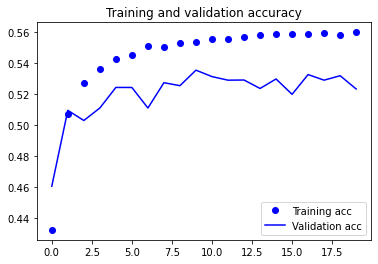

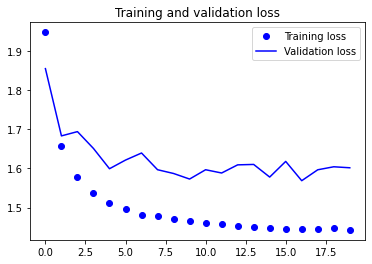

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### GRU Model 6 - 1 GRU layer with 128 recurrent units

In [21]:
model = keras.models.Sequential()
model.add(layers.GRU(128, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 128)               63360     
                                                                 
 dense_2 (Dense)             (None, 35)                4515      
                                                                 
Total params: 67,875
Trainable params: 67,875
Non-trainable params: 0
_________________________________________________________________


In [22]:
optimizer = optimizers.RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [23]:
history = model.fit(x, y,
          batch_size=128,
          epochs=20, validation_split=0.2)

start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text + '"')
    
    # Select a text seed at random
start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text + '"')
   
    
for temperature in [0.2, 0.5, 1.0, 1.2]:
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

        # We generate 400 characters
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = model.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

Epoch 1/20
936/936 [==============================] - 89s 93ms/step - loss: 1.8746 - acc: 0.4498 - val_loss: 1.7290 - val_acc: 0.4875
Epoch 2/20
936/936 [==============================] - 91s 97ms/step - loss: 1.5762 - acc: 0.5247 - val_loss: 1.6650 - val_acc: 0.5045
Epoch 3/20
936/936 [==============================] - 90s 96ms/step - loss: 1.5048 - acc: 0.5437 - val_loss: 1.6021 - val_acc: 0.5259
Epoch 4/20
936/936 [==============================] - 94s 101ms/step - loss: 1.4720 - acc: 0.5521 - val_loss: 1.5939 - val_acc: 0.5247
Epoch 5/20
936/936 [==============================] - 92s 99ms/step - loss: 1.4685 - acc: 0.5542 - val_loss: 1.5845 - val_acc: 0.5324
Epoch 6/20
936/936 [==============================] - 92s 99ms/step - loss: 1.4771 - acc: 0.5514 - val_loss: 1.6285 - val_acc: 0.5128
Epoch 7/20
936/936 [==============================] - 95s 102ms/step - loss: 2.2521 - acc: 0.3598 - val_loss: 2.7025 - val_acc: 0.2241
Epoch 8/20
936/936 [==============================] - 96s 10

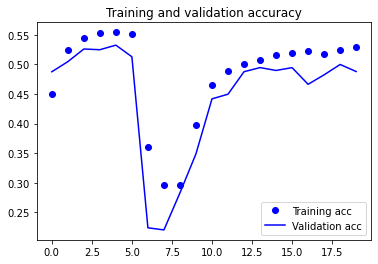

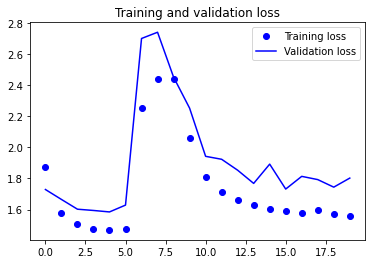

In [24]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### GRU Model 7 - 2 GRU layers with 64 recurrent units

In [57]:
model = keras.models.Sequential()
model.add(layers.GRU(64, return_sequences=True, input_shape=(maxlen, len(chars))))
model.add(layers.GRU(64, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 60, 64)            19392     
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dense_6 (Dense)             (None, 35)                2275      
                                                                 
Total params: 46,627
Trainable params: 46,627
Non-trainable params: 0
_________________________________________________________________


In [58]:
optimizer = optimizers.RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [59]:
history = model.fit(x, y,
          batch_size=128,
          epochs=20, validation_split=0.2)

start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text + '"')
    
    # Select a text seed at random
start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text + '"')
   
    
for temperature in [0.2, 0.5, 1.0, 1.2]:
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

        # We generate 400 characters
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = model.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

Epoch 1/20
936/936 [==============================] - 164s 171ms/step - loss: 1.9217 - acc: 0.4383 - val_loss: 1.8052 - val_acc: 0.4786
Epoch 2/20
936/936 [==============================] - 153s 163ms/step - loss: 1.6331 - acc: 0.5126 - val_loss: 1.6806 - val_acc: 0.4989
Epoch 3/20
936/936 [==============================] - 170s 181ms/step - loss: 1.5617 - acc: 0.5322 - val_loss: 1.7521 - val_acc: 0.4970
Epoch 4/20
936/936 [==============================] - 160s 171ms/step - loss: 1.5355 - acc: 0.5366 - val_loss: 1.7384 - val_acc: 0.4905
Epoch 5/20
936/936 [==============================] - 156s 166ms/step - loss: 1.5186 - acc: 0.5413 - val_loss: 1.6939 - val_acc: 0.4958
Epoch 6/20
936/936 [==============================] - 154s 164ms/step - loss: 1.5155 - acc: 0.5421 - val_loss: 1.6835 - val_acc: 0.5142
Epoch 7/20
936/936 [==============================] - 164s 176ms/step - loss: 1.5104 - acc: 0.5429 - val_loss: 1.6231 - val_acc: 0.5204
Epoch 8/20
936/936 [============================

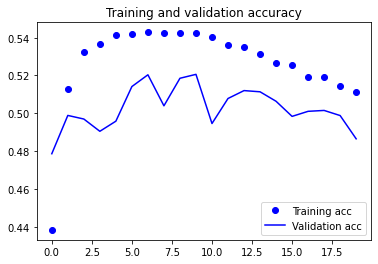

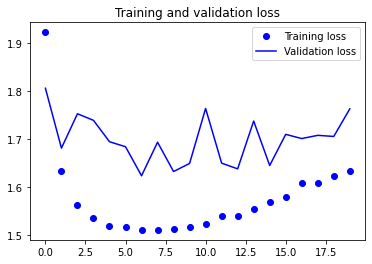

In [60]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### GRU Model 8 - 3 GRU layers with 64 recurrent units

In [61]:
model = keras.models.Sequential()
model.add(layers.GRU(64, return_sequences=True, input_shape=(maxlen, len(chars))))
model.add(layers.GRU(64, return_sequences=True, input_shape=(maxlen, len(chars))))
model.add(layers.GRU(64, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 60, 64)            19392     
                                                                 
 gru_3 (GRU)                 (None, 60, 64)            24960     
                                                                 
 gru_4 (GRU)                 (None, 64)                24960     
                                                                 
 dense_7 (Dense)             (None, 35)                2275      
                                                                 
Total params: 71,587
Trainable params: 71,587
Non-trainable params: 0
_________________________________________________________________


In [62]:
optimizer = optimizers.RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [63]:
history = model.fit(x, y,
          batch_size=128,
          epochs=20, validation_split=0.2)

start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text + '"')
    
    # Select a text seed at random
start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text + '"')
   
    
for temperature in [0.2, 0.5, 1.0, 1.2]:
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

        # We generate 400 characters
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = model.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

Epoch 1/20
936/936 [==============================] - 311s 326ms/step - loss: 1.9902 - acc: 0.4215 - val_loss: 1.9192 - val_acc: 0.4497
Epoch 2/20
936/936 [==============================] - 350s 374ms/step - loss: 1.6933 - acc: 0.4973 - val_loss: 1.8407 - val_acc: 0.4532
Epoch 3/20
936/936 [==============================] - 354s 378ms/step - loss: 1.6548 - acc: 0.5046 - val_loss: 1.8252 - val_acc: 0.4872
Epoch 4/20
936/936 [==============================] - 348s 372ms/step - loss: 1.6520 - acc: 0.5048 - val_loss: 1.7229 - val_acc: 0.4943
Epoch 5/20
936/936 [==============================] - 360s 385ms/step - loss: 1.6694 - acc: 0.5002 - val_loss: 1.7678 - val_acc: 0.4745
Epoch 6/20
936/936 [==============================] - 342s 366ms/step - loss: 1.6877 - acc: 0.4955 - val_loss: 1.7427 - val_acc: 0.4735
Epoch 7/20
936/936 [==============================] - 344s 368ms/step - loss: 1.6900 - acc: 0.4943 - val_loss: 1.7782 - val_acc: 0.4750
Epoch 8/20
936/936 [============================

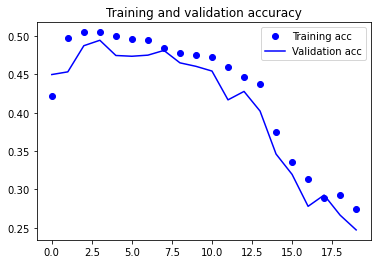

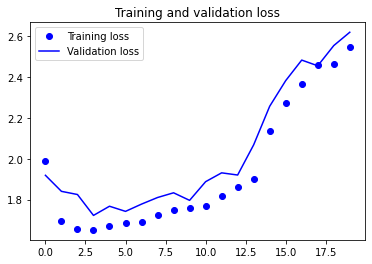

In [64]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Step 2: Determine Optimal Batch Size and Optimizer

#### GRU Model 9 - Batch size 32

In [73]:
model = keras.models.Sequential()
model.add(layers.GRU(64, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_5 (GRU)                 (None, 64)                19392     
                                                                 
 dense_10 (Dense)            (None, 35)                2275      
                                                                 
Total params: 21,667
Trainable params: 21,667
Non-trainable params: 0
_________________________________________________________________


In [74]:
optimizer = optimizers.RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [75]:
history = model.fit(x, y,
          batch_size=32,
          epochs=20, validation_split=0.2)

    # Select a text seed at random
start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text + '"')
   
    
for temperature in [0.2, 0.5, 1.0, 1.2]:
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

        # We generate 400 characters
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = model.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

Epoch 1/20
3741/3741 [==============================] - 118s 31ms/step - loss: 1.9096 - acc: 0.4445 - val_loss: 1.7947 - val_acc: 0.4774
Epoch 2/20
3741/3741 [==============================] - 116s 31ms/step - loss: 1.7196 - acc: 0.4953 - val_loss: 1.7542 - val_acc: 0.4851
Epoch 3/20
3741/3741 [==============================] - 118s 31ms/step - loss: 1.6840 - acc: 0.5040 - val_loss: 1.7077 - val_acc: 0.4988
Epoch 4/20
3741/3741 [==============================] - 118s 31ms/step - loss: 1.6723 - acc: 0.5062 - val_loss: 1.7391 - val_acc: 0.4923
Epoch 5/20
3741/3741 [==============================] - 131s 35ms/step - loss: 1.6687 - acc: 0.5058 - val_loss: 1.7318 - val_acc: 0.4942
Epoch 6/20
3741/3741 [==============================] - 129s 35ms/step - loss: 1.6692 - acc: 0.5066 - val_loss: 1.7429 - val_acc: 0.4923
Epoch 7/20
3741/3741 [==============================] - 129s 35ms/step - loss: 1.6706 - acc: 0.5074 - val_loss: 1.7399 - val_acc: 0.4917
Epoch 8/20
3741/3741 [===================

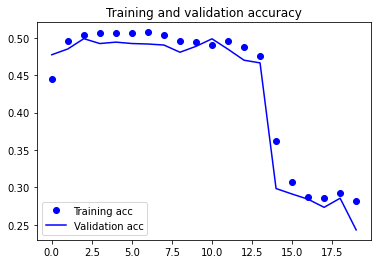

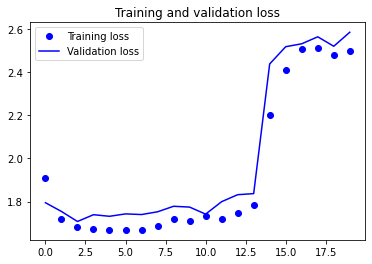

In [76]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### GRU Model 10 - Batch size 64

In [77]:
model = keras.models.Sequential()
model.add(layers.GRU(64, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 64)                19392     
                                                                 
 dense_11 (Dense)            (None, 35)                2275      
                                                                 
Total params: 21,667
Trainable params: 21,667
Non-trainable params: 0
_________________________________________________________________


In [78]:
optimizer = optimizers.RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [79]:
history = model.fit(x, y,
          batch_size=64,
          epochs=20, validation_split=0.2)
    
    # Select a text seed at random
start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text + '"')
   
    
for temperature in [0.2, 0.5, 1.0, 1.2]:
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

        # We generate 400 characters
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = model.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

Epoch 1/20
1871/1871 [==============================] - 74s 38ms/step - loss: 1.9134 - acc: 0.4410 - val_loss: 1.7462 - val_acc: 0.4928
Epoch 2/20
1871/1871 [==============================] - 75s 40ms/step - loss: 1.6654 - acc: 0.5061 - val_loss: 1.7238 - val_acc: 0.5001
Epoch 3/20
1871/1871 [==============================] - 77s 41ms/step - loss: 1.6059 - acc: 0.5217 - val_loss: 1.6738 - val_acc: 0.5071
Epoch 4/20
1871/1871 [==============================] - 74s 40ms/step - loss: 1.5798 - acc: 0.5272 - val_loss: 1.6422 - val_acc: 0.5136
Epoch 5/20
1871/1871 [==============================] - 75s 40ms/step - loss: 1.5670 - acc: 0.5306 - val_loss: 1.6631 - val_acc: 0.5032
Epoch 6/20
1871/1871 [==============================] - 74s 39ms/step - loss: 1.5558 - acc: 0.5341 - val_loss: 1.6456 - val_acc: 0.5163
Epoch 7/20
1871/1871 [==============================] - 77s 41ms/step - loss: 1.5505 - acc: 0.5336 - val_loss: 1.6374 - val_acc: 0.5198
Epoch 8/20
1871/1871 [==========================

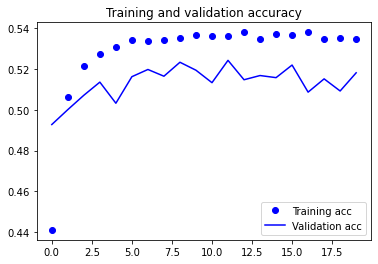

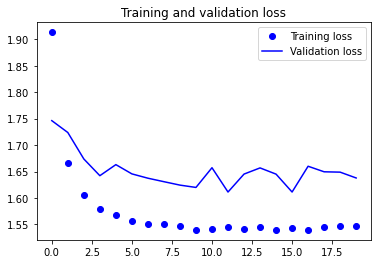

In [80]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### GRU Model 11 - Batch size 256

In [81]:
model = keras.models.Sequential()
model.add(layers.GRU(64, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_7 (GRU)                 (None, 64)                19392     
                                                                 
 dense_12 (Dense)            (None, 35)                2275      
                                                                 
Total params: 21,667
Trainable params: 21,667
Non-trainable params: 0
_________________________________________________________________


In [82]:
optimizer = optimizers.RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [83]:
history = model.fit(x, y,
          batch_size=256,
          epochs=20, validation_split=0.2)

    # Select a text seed at random
start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text + '"')
   
    
for temperature in [0.2, 0.5, 1.0, 1.2]:
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

        # We generate 400 characters
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = model.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

Epoch 1/20
468/468 [==============================] - 85s 179ms/step - loss: 2.0194 - acc: 0.4133 - val_loss: 1.7802 - val_acc: 0.4763
Epoch 2/20
468/468 [==============================] - 84s 179ms/step - loss: 1.6774 - acc: 0.5008 - val_loss: 1.6764 - val_acc: 0.5042
Epoch 3/20
468/468 [==============================] - 84s 181ms/step - loss: 1.5819 - acc: 0.5259 - val_loss: 1.6166 - val_acc: 0.5162
Epoch 4/20
468/468 [==============================] - 92s 197ms/step - loss: 1.5318 - acc: 0.5375 - val_loss: 1.5886 - val_acc: 0.5288
Epoch 5/20
468/468 [==============================] - 78s 167ms/step - loss: 1.4974 - acc: 0.5483 - val_loss: 1.5703 - val_acc: 0.5310
Epoch 6/20
468/468 [==============================] - 77s 165ms/step - loss: 1.4728 - acc: 0.5531 - val_loss: 1.5609 - val_acc: 0.5395
Epoch 7/20
468/468 [==============================] - 79s 169ms/step - loss: 1.4562 - acc: 0.5579 - val_loss: 1.5540 - val_acc: 0.5380
Epoch 8/20
468/468 [==============================] - 8

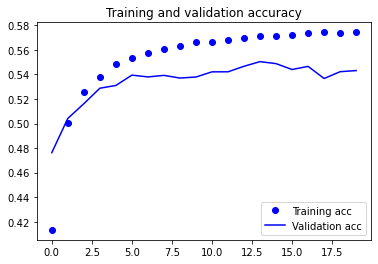

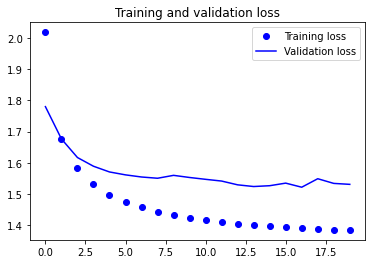

In [84]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### GRU Model 12 - Batch size 512

In [85]:
model = keras.models.Sequential()
model.add(layers.GRU(64, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_8 (GRU)                 (None, 64)                19392     
                                                                 
 dense_13 (Dense)            (None, 35)                2275      
                                                                 
Total params: 21,667
Trainable params: 21,667
Non-trainable params: 0
_________________________________________________________________


In [86]:
optimizer = optimizers.RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [87]:
history = model.fit(x, y,
          batch_size=512,
          epochs=20, validation_split=0.2)
    
    # Select a text seed at random
start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text + '"')
   
    
for temperature in [0.2, 0.5, 1.0, 1.2]:
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

        # We generate 400 characters
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = model.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

Epoch 1/20
234/234 [==============================] - 63s 262ms/step - loss: 2.1370 - acc: 0.3812 - val_loss: 1.8780 - val_acc: 0.4525
Epoch 2/20
234/234 [==============================] - 64s 275ms/step - loss: 1.7447 - acc: 0.4831 - val_loss: 1.6930 - val_acc: 0.5019
Epoch 3/20
234/234 [==============================] - 65s 278ms/step - loss: 1.6226 - acc: 0.5151 - val_loss: 1.6384 - val_acc: 0.5145
Epoch 4/20
234/234 [==============================] - 64s 273ms/step - loss: 1.5566 - acc: 0.5323 - val_loss: 1.5909 - val_acc: 0.5238
Epoch 5/20
234/234 [==============================] - 64s 273ms/step - loss: 1.5125 - acc: 0.5436 - val_loss: 1.5736 - val_acc: 0.5313
Epoch 6/20
234/234 [==============================] - 65s 279ms/step - loss: 1.4816 - acc: 0.5507 - val_loss: 1.5704 - val_acc: 0.5341
Epoch 7/20
234/234 [==============================] - 64s 273ms/step - loss: 1.4589 - acc: 0.5575 - val_loss: 1.5505 - val_acc: 0.5417
Epoch 8/20
234/234 [==============================] - 6

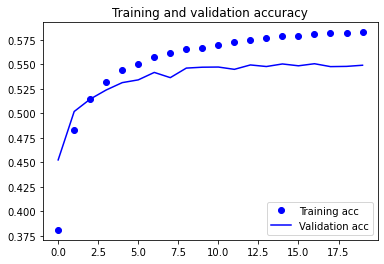

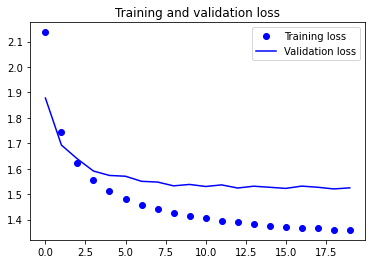

In [88]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### GRU Model 13 - Adam optimizer

In [131]:
model = keras.models.Sequential()
model.add(layers.GRU(64, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_12 (GRU)                (None, 64)                19392     
                                                                 
 dense_25 (Dense)            (None, 35)                2275      
                                                                 
Total params: 21,667
Trainable params: 21,667
Non-trainable params: 0
_________________________________________________________________


In [132]:
optimizer = optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [133]:
history = model.fit(x, y,
          batch_size=512,
          epochs=20, validation_split=0.2)

    
    # Select a text seed at random
start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text + '"')
   
    
for temperature in [0.2, 0.5, 1.0, 1.2]:
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

        # We generate 400 characters
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = model.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

Epoch 1/20
234/234 [==============================] - 98s 410ms/step - loss: 2.1978 - acc: 0.3653 - val_loss: 1.8669 - val_acc: 0.4577
Epoch 2/20
234/234 [==============================] - 98s 421ms/step - loss: 1.7450 - acc: 0.4847 - val_loss: 1.7007 - val_acc: 0.5031
Epoch 3/20
234/234 [==============================] - 99s 422ms/step - loss: 1.6118 - acc: 0.5188 - val_loss: 1.6297 - val_acc: 0.5145
Epoch 4/20
234/234 [==============================] - 96s 412ms/step - loss: 1.5456 - acc: 0.5331 - val_loss: 1.5977 - val_acc: 0.5252
Epoch 5/20
234/234 [==============================] - 92s 395ms/step - loss: 1.4994 - acc: 0.5437 - val_loss: 1.5710 - val_acc: 0.5317
Epoch 6/20
234/234 [==============================] - 94s 403ms/step - loss: 1.4714 - acc: 0.5521 - val_loss: 1.5627 - val_acc: 0.5331
Epoch 7/20
234/234 [==============================] - 94s 402ms/step - loss: 1.4489 - acc: 0.5571 - val_loss: 1.5458 - val_acc: 0.5412
Epoch 8/20
234/234 [==============================] - 9

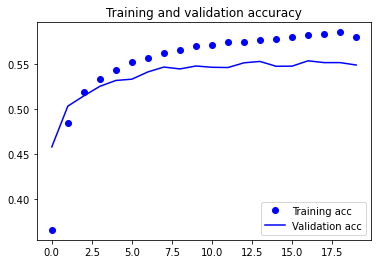

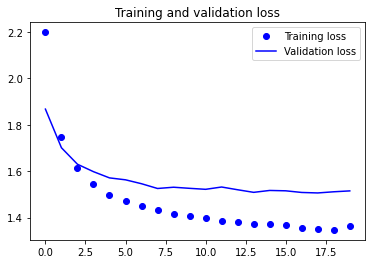

In [134]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### GRU Model 14 - Rectified Adam optimizer

In [140]:
model = keras.models.Sequential()
model.add(layers.GRU(64, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_14 (GRU)                (None, 64)                19392     
                                                                 
 dense_27 (Dense)            (None, 35)                2275      
                                                                 
Total params: 21,667
Trainable params: 21,667
Non-trainable params: 0
_________________________________________________________________


In [141]:
optimizer = RAdam()
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [142]:
history = model.fit(x, y,
          batch_size=512,
          epochs=20, validation_split=0.2)

    
    # Select a text seed at random
start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text + '"')
   
    
for temperature in [0.2, 0.5, 1.0, 1.2]:
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

        # We generate 400 characters
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = model.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

Epoch 1/40
234/234 [==============================] - 98s 410ms/step - loss: 3.2064 - acc: 0.1515 - val_loss: 2.8842 - val_acc: 0.1836
Epoch 2/40
234/234 [==============================] - 88s 375ms/step - loss: 2.7427 - acc: 0.2189 - val_loss: 2.6102 - val_acc: 0.2672
Epoch 3/40
234/234 [==============================] - 91s 390ms/step - loss: 2.4752 - acc: 0.3026 - val_loss: 2.4021 - val_acc: 0.3098
Epoch 4/40
234/234 [==============================] - 111s 473ms/step - loss: 2.3220 - acc: 0.3299 - val_loss: 2.2890 - val_acc: 0.3373
Epoch 5/40
234/234 [==============================] - 91s 389ms/step - loss: 2.2267 - acc: 0.3519 - val_loss: 2.2049 - val_acc: 0.3637
Epoch 6/40
234/234 [==============================] - 91s 390ms/step - loss: 2.1479 - acc: 0.3735 - val_loss: 2.1338 - val_acc: 0.3843
Epoch 7/40
234/234 [==============================] - 93s 397ms/step - loss: 2.0803 - acc: 0.3978 - val_loss: 2.0695 - val_acc: 0.4053
Epoch 8/40
234/234 [==============================] - 

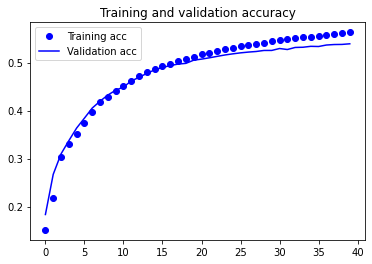

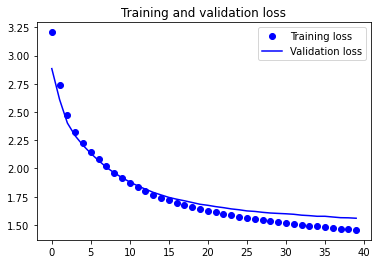

In [143]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Step 3: Reduce Overfitting

#### GRU Model 17 - None

In [12]:
from keras import regularizers
model = keras.models.Sequential()
model.add(layers.GRU(64, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                19392     
                                                                 
 dense (Dense)               (None, 35)                2275      
                                                                 
Total params: 21,667
Trainable params: 21,667
Non-trainable params: 0
_________________________________________________________________


In [13]:
optimizer = optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [14]:
history = model.fit(x, y,
          batch_size=512,
          epochs=40, validation_split=0.2)

Epoch 1/40
234/234 [==============================] - 37s 147ms/step - loss: 2.1729 - acc: 0.3712 - val_loss: 1.8681 - val_acc: 0.4497
Epoch 2/40
234/234 [==============================] - 35s 150ms/step - loss: 1.7403 - acc: 0.4840 - val_loss: 1.6916 - val_acc: 0.5002
Epoch 3/40
234/234 [==============================] - 34s 147ms/step - loss: 1.6110 - acc: 0.5176 - val_loss: 1.6168 - val_acc: 0.5204
Epoch 4/40
234/234 [==============================] - 31s 134ms/step - loss: 1.5422 - acc: 0.5346 - val_loss: 1.5906 - val_acc: 0.5253
Epoch 5/40
234/234 [==============================] - 31s 131ms/step - loss: 1.5004 - acc: 0.5470 - val_loss: 1.5698 - val_acc: 0.5331
Epoch 6/40
234/234 [==============================] - 30s 129ms/step - loss: 1.4700 - acc: 0.5540 - val_loss: 1.5580 - val_acc: 0.5342
Epoch 7/40
234/234 [==============================] - 31s 132ms/step - loss: 1.4487 - acc: 0.5602 - val_loss: 1.5479 - val_acc: 0.5370
Epoch 8/40
234/234 [==============================] - 3

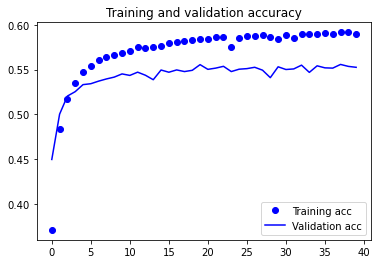

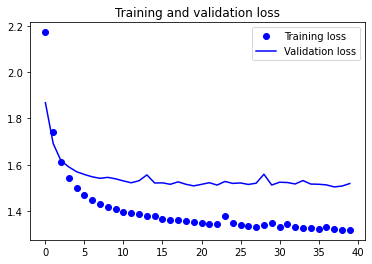

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### GRU Model 18 - Only L2 regularization

In [16]:
from keras import regularizers
model = keras.models.Sequential()
model.add(layers.GRU(64, recurrent_regularizer = regularizers.l2(0.001), input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 64)                19392     
                                                                 
 dense_1 (Dense)             (None, 35)                2275      
                                                                 
Total params: 21,667
Trainable params: 21,667
Non-trainable params: 0
_________________________________________________________________


In [17]:
optimizer = optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [18]:
history = model.fit(x, y,
          batch_size=512,
          epochs=40, validation_split=0.2)

Epoch 1/40
234/234 [==============================] - 33s 132ms/step - loss: 2.2662 - acc: 0.3562 - val_loss: 2.0210 - val_acc: 0.4203
Epoch 2/40
234/234 [==============================] - 33s 139ms/step - loss: 1.9327 - acc: 0.4490 - val_loss: 1.9137 - val_acc: 0.4529
Epoch 3/40
234/234 [==============================] - 33s 140ms/step - loss: 1.8410 - acc: 0.4765 - val_loss: 1.8339 - val_acc: 0.4850
Epoch 4/40
234/234 [==============================] - 36s 153ms/step - loss: 1.7899 - acc: 0.4919 - val_loss: 1.8075 - val_acc: 0.4908
Epoch 5/40
234/234 [==============================] - 31s 134ms/step - loss: 1.7593 - acc: 0.4994 - val_loss: 1.7929 - val_acc: 0.4966
Epoch 6/40
234/234 [==============================] - 33s 143ms/step - loss: 1.7388 - acc: 0.5054 - val_loss: 1.7728 - val_acc: 0.4990
Epoch 7/40
234/234 [==============================] - 30s 129ms/step - loss: 1.7199 - acc: 0.5105 - val_loss: 1.7743 - val_acc: 0.4920
Epoch 8/40
234/234 [==============================] - 3

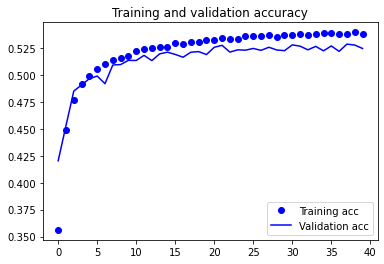

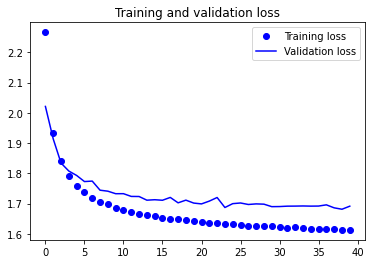

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### GRU Model 19 - Only Regular dropout

In [20]:
model = keras.models.Sequential()
model.add(layers.GRU(64, dropout=0.1, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 64)                19392     
                                                                 
 dense_2 (Dense)             (None, 35)                2275      
                                                                 
Total params: 21,667
Trainable params: 21,667
Non-trainable params: 0
_________________________________________________________________


In [21]:
optimizer = optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [22]:
history = model.fit(x, y,
          batch_size=512,
          epochs=40, validation_split=0.2)


Epoch 1/40
234/234 [==============================] - 39s 155ms/step - loss: 2.2973 - acc: 0.3366 - val_loss: 1.9189 - val_acc: 0.4433
Epoch 2/40
234/234 [==============================] - 34s 147ms/step - loss: 1.9168 - acc: 0.4363 - val_loss: 1.7345 - val_acc: 0.4888
Epoch 3/40
234/234 [==============================] - 35s 149ms/step - loss: 1.8014 - acc: 0.4675 - val_loss: 1.6700 - val_acc: 0.5058
Epoch 4/40
234/234 [==============================] - 35s 149ms/step - loss: 1.7451 - acc: 0.4795 - val_loss: 1.6243 - val_acc: 0.5143
Epoch 5/40
234/234 [==============================] - 34s 144ms/step - loss: 1.7112 - acc: 0.4869 - val_loss: 1.5971 - val_acc: 0.5213
Epoch 6/40
234/234 [==============================] - 37s 157ms/step - loss: 1.6848 - acc: 0.4929 - val_loss: 1.5793 - val_acc: 0.5271
Epoch 7/40
234/234 [==============================] - 33s 143ms/step - loss: 1.6673 - acc: 0.4968 - val_loss: 1.5724 - val_acc: 0.5276
Epoch 8/40
234/234 [==============================] - 3

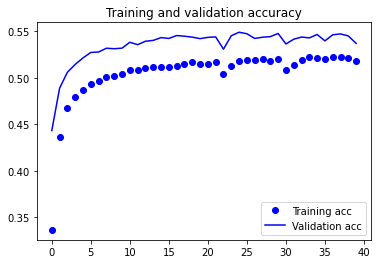

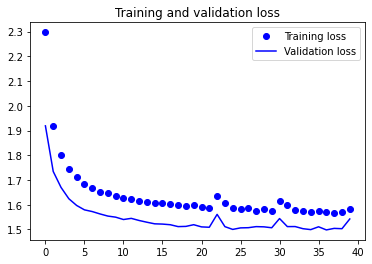

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### GRU Model 20 - Only Recurrent Dropout

In [13]:
model = keras.models.Sequential()
model.add(layers.GRU(64, recurrent_dropout=0.1, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                19392     
                                                                 
 dense (Dense)               (None, 35)                2275      
                                                                 
Total params: 21,667
Trainable params: 21,667
Non-trainable params: 0
_________________________________________________________________


In [14]:
optimizer = optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [15]:
history = model.fit(x, y,
          batch_size=512,
          epochs=40, validation_split=0.2)


Epoch 1/40
234/234 [==============================] - 59s 244ms/step - loss: 2.2022 - acc: 0.3637 - val_loss: 1.8923 - val_acc: 0.4452
Epoch 2/40
234/234 [==============================] - 48s 205ms/step - loss: 1.8029 - acc: 0.4683 - val_loss: 1.7241 - val_acc: 0.4963
Epoch 3/40
234/234 [==============================] - 47s 199ms/step - loss: 1.6956 - acc: 0.4959 - val_loss: 1.6581 - val_acc: 0.5064
Epoch 4/40
234/234 [==============================] - 41s 175ms/step - loss: 1.6439 - acc: 0.5063 - val_loss: 1.6257 - val_acc: 0.5121
Epoch 5/40
234/234 [==============================] - 41s 173ms/step - loss: 1.6106 - acc: 0.5130 - val_loss: 1.5911 - val_acc: 0.5240
Epoch 6/40
234/234 [==============================] - 41s 173ms/step - loss: 1.5874 - acc: 0.5193 - val_loss: 1.5769 - val_acc: 0.5258
Epoch 7/40
234/234 [==============================] - 41s 177ms/step - loss: 1.5683 - acc: 0.5239 - val_loss: 1.5663 - val_acc: 0.5305
Epoch 8/40
234/234 [==============================] - 4

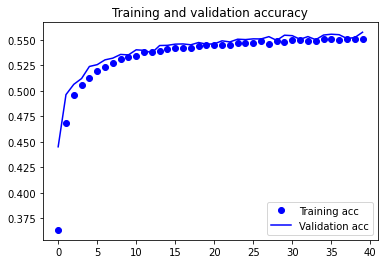

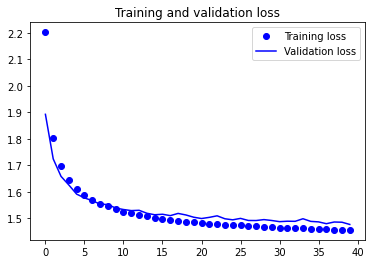

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### GRU Model 21 - Recurrent dropout + regular dropout

In [17]:
model = keras.models.Sequential()
model.add(layers.GRU(64, recurrent_dropout=0.1, dropout=0.1,input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 64)                19392     
                                                                 
 dense_1 (Dense)             (None, 35)                2275      
                                                                 
Total params: 21,667
Trainable params: 21,667
Non-trainable params: 0
_________________________________________________________________


In [18]:
optimizer = optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [19]:
history = model.fit(x, y,
          batch_size=512,
          epochs=40, validation_split=0.2)


Epoch 1/40
234/234 [==============================] - 54s 221ms/step - loss: 2.2864 - acc: 0.3385 - val_loss: 1.9350 - val_acc: 0.4318
Epoch 2/40
234/234 [==============================] - 51s 220ms/step - loss: 1.9034 - acc: 0.4365 - val_loss: 1.7656 - val_acc: 0.4834
Epoch 3/40
234/234 [==============================] - 51s 219ms/step - loss: 1.7955 - acc: 0.4676 - val_loss: 1.6813 - val_acc: 0.5057
Epoch 4/40
234/234 [==============================] - 51s 216ms/step - loss: 1.7467 - acc: 0.4796 - val_loss: 1.6547 - val_acc: 0.5058
Epoch 5/40
234/234 [==============================] - 51s 218ms/step - loss: 1.7154 - acc: 0.4853 - val_loss: 1.6195 - val_acc: 0.5169
Epoch 6/40
234/234 [==============================] - 51s 220ms/step - loss: 1.6928 - acc: 0.4929 - val_loss: 1.6116 - val_acc: 0.5181
Epoch 7/40
234/234 [==============================] - 50s 216ms/step - loss: 1.6784 - acc: 0.4962 - val_loss: 1.6024 - val_acc: 0.5203
Epoch 8/40
234/234 [==============================] - 5

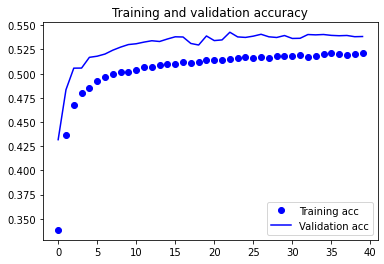

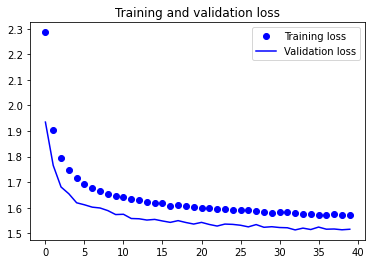

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### GRU Model 22 - L2 regularization + regular dropout

In [22]:
from keras import regularizers
model = keras.models.Sequential()
model.add(layers.GRU(64, recurrent_regularizer=regularizers.l2(0.001), dropout=0.1,input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 64)                19392     
                                                                 
 dense_2 (Dense)             (None, 35)                2275      
                                                                 
Total params: 21,667
Trainable params: 21,667
Non-trainable params: 0
_________________________________________________________________


In [23]:
optimizer = optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [24]:
history = model.fit(x, y,
          batch_size=512,
          epochs=40, validation_split=0.2)


Epoch 1/40
234/234 [==============================] - 33s 132ms/step - loss: 2.3689 - acc: 0.3286 - val_loss: 2.0705 - val_acc: 0.4103
Epoch 2/40
234/234 [==============================] - 33s 141ms/step - loss: 2.0824 - acc: 0.4052 - val_loss: 1.9296 - val_acc: 0.4563
Epoch 3/40
234/234 [==============================] - 34s 145ms/step - loss: 2.0065 - acc: 0.4292 - val_loss: 1.8768 - val_acc: 0.4652
Epoch 4/40
234/234 [==============================] - 33s 143ms/step - loss: 1.9628 - acc: 0.4434 - val_loss: 1.8419 - val_acc: 0.4785
Epoch 5/40
234/234 [==============================] - 33s 139ms/step - loss: 1.9345 - acc: 0.4510 - val_loss: 1.8024 - val_acc: 0.4896
Epoch 6/40
234/234 [==============================] - 33s 141ms/step - loss: 1.9191 - acc: 0.4543 - val_loss: 1.8093 - val_acc: 0.4925
Epoch 7/40
234/234 [==============================] - 34s 143ms/step - loss: 1.9061 - acc: 0.4568 - val_loss: 1.7854 - val_acc: 0.4972
Epoch 8/40
234/234 [==============================] - 3

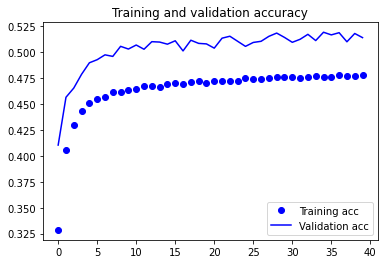

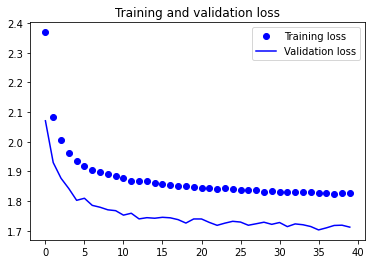

In [25]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### GRU Model 23 - Recurrent dropout + L2 regularization

In [26]:
model = keras.models.Sequential()
model.add(layers.GRU(64, recurrent_regularizer=regularizers.l2(0.001), recurrent_dropout=0.1,input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 64)                19392     
                                                                 
 dense_3 (Dense)             (None, 35)                2275      
                                                                 
Total params: 21,667
Trainable params: 21,667
Non-trainable params: 0
_________________________________________________________________


In [27]:
optimizer = optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [28]:
history = model.fit(x, y,
          batch_size=512,
          epochs=40, validation_split=0.2)


Epoch 1/40
234/234 [==============================] - 46s 189ms/step - loss: 2.2783 - acc: 0.3504 - val_loss: 2.0393 - val_acc: 0.4116
Epoch 2/40
234/234 [==============================] - 45s 190ms/step - loss: 1.9584 - acc: 0.4383 - val_loss: 1.9191 - val_acc: 0.4530
Epoch 3/40
234/234 [==============================] - 44s 190ms/step - loss: 1.8732 - acc: 0.4648 - val_loss: 1.8547 - val_acc: 0.4706
Epoch 4/40
234/234 [==============================] - 44s 190ms/step - loss: 1.8282 - acc: 0.4784 - val_loss: 1.8217 - val_acc: 0.4833
Epoch 5/40
234/234 [==============================] - 44s 188ms/step - loss: 1.8027 - acc: 0.4851 - val_loss: 1.8044 - val_acc: 0.4932
Epoch 6/40
234/234 [==============================] - 44s 189ms/step - loss: 1.7796 - acc: 0.4932 - val_loss: 1.7702 - val_acc: 0.4961
Epoch 7/40
234/234 [==============================] - 45s 190ms/step - loss: 1.7663 - acc: 0.4937 - val_loss: 1.7714 - val_acc: 0.4978
Epoch 8/40
234/234 [==============================] - 4

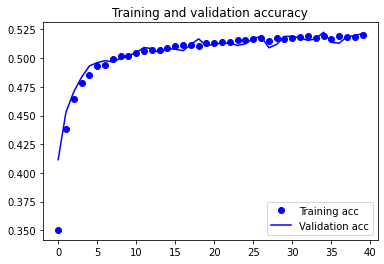

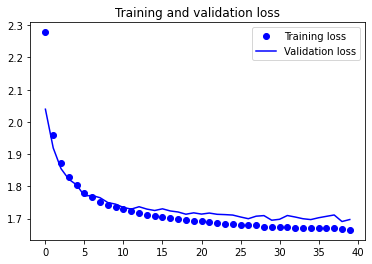

In [29]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### GRU Model 24 - Recurrent dropout + regular dropout + L2 regularizer

In [30]:
model = keras.models.Sequential()
model.add(layers.GRU(64, recurrent_regularizer=regularizers.l2(0.001), recurrent_dropout=0.1, dropout=0.1, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 64)                19392     
                                                                 
 dense_4 (Dense)             (None, 35)                2275      
                                                                 
Total params: 21,667
Trainable params: 21,667
Non-trainable params: 0
_________________________________________________________________


In [31]:
optimizer = optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [32]:
history = model.fit(x, y,
          batch_size=512,
          epochs=40, validation_split=0.2)


Epoch 1/40
234/234 [==============================] - 52s 217ms/step - loss: 2.3487 - acc: 0.3323 - val_loss: 2.0742 - val_acc: 0.3988
Epoch 2/40
234/234 [==============================] - 50s 214ms/step - loss: 2.0483 - acc: 0.4134 - val_loss: 1.9360 - val_acc: 0.4462
Epoch 3/40
234/234 [==============================] - 50s 213ms/step - loss: 1.9631 - acc: 0.4390 - val_loss: 1.8835 - val_acc: 0.4678
Epoch 4/40
234/234 [==============================] - 49s 210ms/step - loss: 1.9167 - acc: 0.4533 - val_loss: 1.8560 - val_acc: 0.4726
Epoch 5/40
234/234 [==============================] - 49s 210ms/step - loss: 1.8881 - acc: 0.4608 - val_loss: 1.8176 - val_acc: 0.4853
Epoch 6/40
234/234 [==============================] - 49s 211ms/step - loss: 1.8746 - acc: 0.4658 - val_loss: 1.8135 - val_acc: 0.4860
Epoch 7/40
234/234 [==============================] - 50s 212ms/step - loss: 1.8596 - acc: 0.4681 - val_loss: 1.8097 - val_acc: 0.4871
Epoch 8/40
234/234 [==============================] - 5

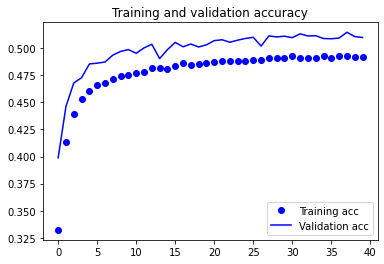

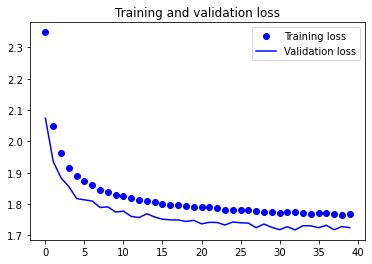

In [33]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Retraining GRU Model 17 until it overfits

In [34]:
model = keras.models.Sequential()
model.add(layers.GRU(64, recurrent_dropout=0.1, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_5 (GRU)                 (None, 64)                19392     
                                                                 
 dense_5 (Dense)             (None, 35)                2275      
                                                                 
Total params: 21,667
Trainable params: 21,667
Non-trainable params: 0
_________________________________________________________________


In [35]:
optimizer = optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [36]:
history = model.fit(x, y, batch_size=512,epochs=100, validation_split=0.2, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)])


    # Select a text seed at random
start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text + '"')
   
    
for temperature in [0.2, 0.5, 1.0, 1.2]:
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

        # We generate 400 characters
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = model.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

Epoch 1/100
234/234 [==============================] - 48s 198ms/step - loss: 2.2056 - acc: 0.3619 - val_loss: 1.8916 - val_acc: 0.4480
Epoch 2/100
234/234 [==============================] - 58s 247ms/step - loss: 1.8027 - acc: 0.4666 - val_loss: 1.7145 - val_acc: 0.4932
Epoch 3/100
234/234 [==============================] - 58s 248ms/step - loss: 1.6948 - acc: 0.4955 - val_loss: 1.6543 - val_acc: 0.5098
Epoch 4/100
234/234 [==============================] - 74s 317ms/step - loss: 1.6414 - acc: 0.5078 - val_loss: 1.6226 - val_acc: 0.5196
Epoch 5/100
234/234 [==============================] - 72s 310ms/step - loss: 1.6080 - acc: 0.5167 - val_loss: 1.6043 - val_acc: 0.5230
Epoch 6/100
234/234 [==============================] - 72s 308ms/step - loss: 1.5840 - acc: 0.5243 - val_loss: 1.5787 - val_acc: 0.5282
Epoch 7/100
234/234 [==============================] - 73s 313ms/step - loss: 1.5649 - acc: 0.5267 - val_loss: 1.5656 - val_acc: 0.5312
Epoch 8/100
234/234 [===========================

Epoch 61/100
234/234 [==============================] - 68s 289ms/step - loss: 1.4349 - acc: 0.5571 - val_loss: 1.4723 - val_acc: 0.5559
Epoch 62/100
234/234 [==============================] - 71s 302ms/step - loss: 1.4333 - acc: 0.5582 - val_loss: 1.4728 - val_acc: 0.5550
Epoch 63/100
234/234 [==============================] - 67s 287ms/step - loss: 1.4326 - acc: 0.5572 - val_loss: 1.4728 - val_acc: 0.5561
Epoch 64/100
234/234 [==============================] - 68s 290ms/step - loss: 1.4337 - acc: 0.5574 - val_loss: 1.4741 - val_acc: 0.5549
Epoch 65/100
234/234 [==============================] - 68s 291ms/step - loss: 1.4347 - acc: 0.5575 - val_loss: 1.4698 - val_acc: 0.5592
Epoch 66/100
234/234 [==============================] - 70s 297ms/step - loss: 1.4334 - acc: 0.5590 - val_loss: 1.4673 - val_acc: 0.5593
Epoch 67/100
234/234 [==============================] - 67s 287ms/step - loss: 1.4305 - acc: 0.5582 - val_loss: 1.4724 - val_acc: 0.5570
Epoch 68/100
234/234 [===================

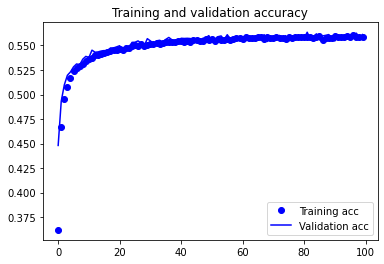

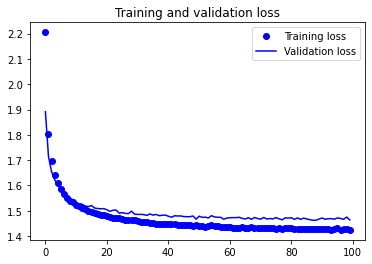

In [37]:

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 3. 1D Convnets

### 1D Convnet Model 1

In [194]:
model = Sequential()
model.add(layers.Conv1D(filters=32, input_shape=(maxlen, len(chars)), activation='relu', kernel_size=4))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(filters=32, activation='relu', kernel_size=4))
model.add(Flatten())
model.add(layers.Dense(len(chars), activation='softmax'))
model.summary()

model.compile(optimizer=optimizers.RMSprop(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['acc'])

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 57, 32)            4512      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 11, 32)           0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 8, 32)             4128      
                                                                 
 flatten_3 (Flatten)         (None, 256)               0         
                                                                 
 dense_40 (Dense)            (None, 35)                8995      
                                                                 
Total params: 17,635
Trainable params: 17,635
Non-trainable params: 0
_________________________________________________

In [195]:
history = model.fit(x, y,
          batch_size=512,
          epochs=20, validation_split=0.2)


Epoch 1/20
234/234 [==============================] - 19s 76ms/step - loss: 2.8983 - acc: 0.2002 - val_loss: 2.8499 - val_acc: 0.2167
Epoch 2/20
234/234 [==============================] - 16s 70ms/step - loss: 2.8090 - acc: 0.2204 - val_loss: 2.8147 - val_acc: 0.2196
Epoch 3/20
234/234 [==============================] - 17s 72ms/step - loss: 2.7903 - acc: 0.2228 - val_loss: 2.8075 - val_acc: 0.2204
Epoch 4/20
234/234 [==============================] - 16s 69ms/step - loss: 2.7769 - acc: 0.2254 - val_loss: 2.8039 - val_acc: 0.2211
Epoch 5/20
234/234 [==============================] - 16s 69ms/step - loss: 2.7661 - acc: 0.2263 - val_loss: 2.7958 - val_acc: 0.2211
Epoch 6/20
234/234 [==============================] - 17s 73ms/step - loss: 2.7587 - acc: 0.2279 - val_loss: 2.7937 - val_acc: 0.2206
Epoch 7/20
234/234 [==============================] - 17s 71ms/step - loss: 2.7532 - acc: 0.2285 - val_loss: 2.7872 - val_acc: 0.2238
Epoch 8/20
234/234 [==============================] - 16s 69ms

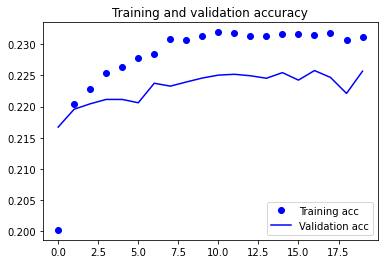

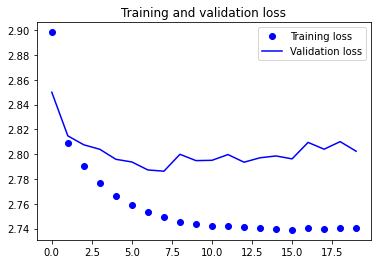

In [196]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 1D Convnet Model 2

In [203]:
model = Sequential()
model.add(layers.Conv1D(filters=64, input_shape=(maxlen, len(chars)), activation='relu', kernel_size=4))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(filters=64, activation='relu', kernel_size=4))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(len(chars), activation='softmax'))
model.summary()

model.compile(optimizer=optimizers.RMSprop(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['acc'])

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 57, 64)            9024      
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 11, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_19 (Conv1D)          (None, 8, 64)             16448     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_42 (Dense)            (None, 35)                2275      
                                                                 
Total params: 27,747
Trainable params: 27,747
Non-tra

In [204]:
history = model.fit(x, y,
          batch_size=128,
          epochs=20, validation_split=0.2)

Epoch 1/20
936/936 [==============================] - 35s 37ms/step - loss: 2.9093 - acc: 0.1930 - val_loss: 2.8876 - val_acc: 0.1976
Epoch 2/20
936/936 [==============================] - 34s 37ms/step - loss: 2.8643 - acc: 0.2038 - val_loss: 2.8838 - val_acc: 0.2003
Epoch 3/20
936/936 [==============================] - 40s 42ms/step - loss: 2.8543 - acc: 0.2056 - val_loss: 2.8685 - val_acc: 0.2029
Epoch 4/20
936/936 [==============================] - 36s 39ms/step - loss: 2.8496 - acc: 0.2065 - val_loss: 2.8833 - val_acc: 0.2014
Epoch 5/20
936/936 [==============================] - 36s 39ms/step - loss: 2.8476 - acc: 0.2074 - val_loss: 2.8769 - val_acc: 0.2006
Epoch 6/20
936/936 [==============================] - 37s 40ms/step - loss: 2.8449 - acc: 0.2081 - val_loss: 2.8785 - val_acc: 0.2017
Epoch 7/20
936/936 [==============================] - 39s 41ms/step - loss: 2.8435 - acc: 0.2090 - val_loss: 2.8883 - val_acc: 0.2009
Epoch 8/20
936/936 [==============================] - 37s 40ms

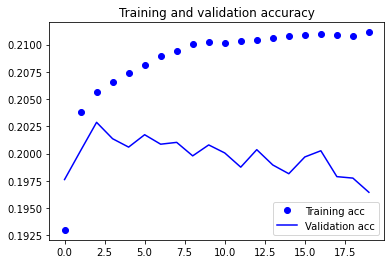

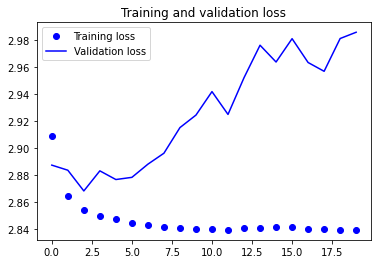

In [205]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 1D Convnet Model 3

In [206]:
model = Sequential()
model.add(layers.Conv1D(filters=64, input_shape=(maxlen, len(chars)), activation='relu', kernel_size=4))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(filters=64, activation='relu', kernel_size=4))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(filters=64, activation='relu', kernel_size=4))
model.add(Flatten())
model.add(layers.Dense(len(chars), activation='softmax'))
model.summary()

model.compile(optimizer=optimizers.Adam(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['acc'])

Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_20 (Conv1D)          (None, 57, 64)            9024      
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 28, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_21 (Conv1D)          (None, 25, 64)            16448     
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 12, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_22 (Conv1D)          (None, 9, 64)             16448     
                                                                 
 flatten_5 (Flatten)         (None, 576)             

In [208]:
history = model.fit(x, y,
          batch_size=32,
          epochs=20, validation_split=0.20)

Epoch 1/20
3741/3741 [==============================] - 85s 22ms/step - loss: 2.8505 - acc: 0.2120 - val_loss: 2.8281 - val_acc: 0.2184
Epoch 2/20
3741/3741 [==============================] - 90s 24ms/step - loss: 2.8561 - acc: 0.2083 - val_loss: 2.9460 - val_acc: 0.1836
Epoch 3/20
3741/3741 [==============================] - 78s 21ms/step - loss: 2.9320 - acc: 0.1869 - val_loss: 2.9465 - val_acc: 0.1836
Epoch 4/20
3741/3741 [==============================] - 78s 21ms/step - loss: 2.9320 - acc: 0.1869 - val_loss: 2.9467 - val_acc: 0.1836
Epoch 5/20
3741/3741 [==============================] - 74s 20ms/step - loss: 2.9322 - acc: 0.1869 - val_loss: 2.9454 - val_acc: 0.1836
Epoch 6/20
3741/3741 [==============================] - 72s 19ms/step - loss: 2.9322 - acc: 0.1869 - val_loss: 2.9463 - val_acc: 0.1836
Epoch 7/20
3741/3741 [==============================] - 74s 20ms/step - loss: 2.9321 - acc: 0.1869 - val_loss: 2.9470 - val_acc: 0.1836
Epoch 8/20
3741/3741 [==========================

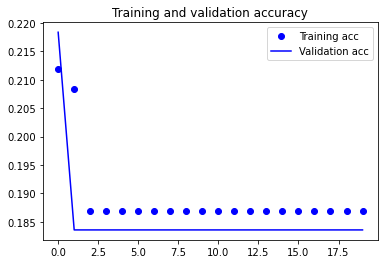

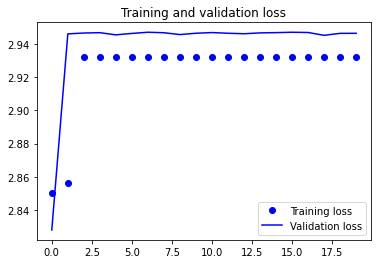

In [209]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Best Performing Model out of the 3 architectures: LSTM Model

### Further experimentations - Bidirectional LSTMs

In [12]:
model = keras.models.Sequential()
model.add(Bidirectional(LSTM(128, recurrent_dropout = 0.1), input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))     
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 256)              167936    
 l)                                                              
                                                                 
 dense (Dense)               (None, 35)                8995      
                                                                 
Total params: 176,931
Trainable params: 176,931
Non-trainable params: 0
_________________________________________________________________


In [13]:
optimizer = optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [14]:
history = model.fit(x, y,
          batch_size=128,
          epochs=100, validation_split=0.2, callbacks=[tf.keras.callbacks.EarlyStopping(
              monitor='val_loss', patience=5, restore_best_weights=True)])

Epoch 1/100
936/936 [==============================] - 294s 310ms/step - loss: 1.9611 - acc: 0.4258 - val_loss: 1.6531 - val_acc: 0.5034
Epoch 2/100
936/936 [==============================] - 266s 284ms/step - loss: 1.5784 - acc: 0.5217 - val_loss: 1.5304 - val_acc: 0.5389
Epoch 3/100
936/936 [==============================] - 281s 301ms/step - loss: 1.4767 - acc: 0.5479 - val_loss: 1.4820 - val_acc: 0.5509
Epoch 4/100
936/936 [==============================] - 285s 305ms/step - loss: 1.4546 - acc: 0.5529 - val_loss: 1.4654 - val_acc: 0.5554
Epoch 5/100
936/936 [==============================] - 285s 305ms/step - loss: 1.3968 - acc: 0.5676 - val_loss: 1.4412 - val_acc: 0.5616
Epoch 6/100
936/936 [==============================] - 311s 333ms/step - loss: 1.3719 - acc: 0.5743 - val_loss: 1.4316 - val_acc: 0.5626
Epoch 7/100
936/936 [==============================] - 301s 321ms/step - loss: 1.3529 - acc: 0.5798 - val_loss: 1.4359 - val_acc: 0.5670
Epoch 8/100
936/936 [====================

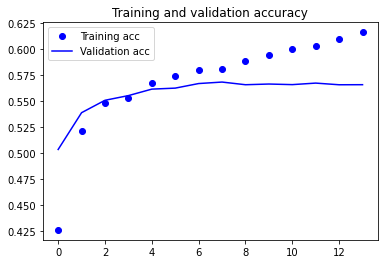

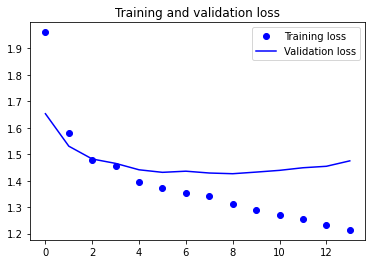

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

###  Analyzing the generated text using temperature sampling

#### Generate text at every epoch

In [12]:
model = keras.models.Sequential()
model.add(layers.LSTM(128, recurrent_dropout = 0.1, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
model.summary()
optimizer = optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               83968     
                                                                 
 dense (Dense)               (None, 35)                4515      
                                                                 
Total params: 88,483
Trainable params: 88,483
Non-trainable params: 0
_________________________________________________________________


In [14]:
import random
import sys

for epoch in range(1, 60):
    print('epoch', epoch)
    # Fit the model for 1 epoch on the available training data
    model.fit(x, y, batch_size=128,epochs=1)

    # Select a text seed at random
    start_index = random.randint(0, len(text) - maxlen - 1)
    generated_text_initial = text[start_index: start_index + maxlen]
    print('--- Generating with seed: "' + generated_text_initial + '"')

    for temperature in [0.2, 0.5, 1.0, 1.2]:
        generated_text = generated_text_initial
        print('------ temperature:', temperature)
        sys.stdout.write(generated_text)

        # We generate 400 characters
        for i in range(400):
            sampled = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1.

            preds = model.predict(sampled, verbose=0)[0] # to get the softmax output
            next_index = sample(preds, temperature)
            next_char = chars[next_index]

            generated_text += next_char
            generated_text = generated_text[1:]

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

epoch 1
1169/1169 [==============================] - 149s 128ms/step - loss: 1.3631 - acc: 0.5788
--- Generating with seed: "t this, neville let out a little moan, and malfoy stopped de"
------ temperature: 0.2
t this, neville let out a little moan, and malfoy stopped deep and still some of the stone to the table of the grapped the stones and said hagrid was strain them to the stone and said hagrid. he was see the stone to the stone to the troll to the stone and they was a seemed to his head the stone was a seen the snape, and they wonder and they street to be she was heard the end of the speed and still the end of the stone to the troll to the end of the stone t
------ temperature: 0.5
t this, neville let out a little moan, and malfoy stopped deeple sorry of the strongers, said hagrid, see his hand a points to see harry while a might to tried back and the around to the face, wonder a brat to the trangers of surring them, something on the life. are they were a with the door at the pale

d neville at the breakfast table. they were all the same: your baggy us read cross owlvel jost-and they splased to it. it wass hundred. back off. harry up, hagrids good dirt. given to know whhes bar and something like his sodestegion. nows by snape corridor down on not and the hall had partmer of. i say, what so hoday privet drivetes their beaking crosomestly other she looked to whick twing boik, and he know to be hip by at other, orly down you want don ea
------ temperature: 1.2
d neville at the breakfast table. they were all the same: youd neck. oh, had gottco very all psef, looked and rote! k the pointer   whondered agett asked a trooling. all the itfortendam. sause wandaly poorly arufift, but not at. ron; mle goyles down and heave he chimsed, hole evenened into harrys supposestified bate  i could meal and i sen it. ouff when theyd hear - gryffindor lytecting seasong. i huven down as hege high dra sk came frey into paper somethe
epoch 9
1169/1169 [==============================] - 1

t tears leaking down into his beard. hagrid, hed have found out the face and heard the dursleys straight and harry had been he had been the count a passe of the straight and the father to his face of the school with the fat of the stone a stairs and started and harry and he was the best the troll for a lot of the straight and the forest the gryffindor had been starting to the stone to the troll with his boy with a lot of the straight and harry started the 
------ temperature: 0.5
t tears leaking down into his beard. hagrid, hed have found out the swhile to hear he had ever to like a streak and of the stair and one heads a face and stepped the stone was almost the front of the possibly said harry. i can studying at his last shoop of the room. weve took him the letter and he had been as it was a passe and harry as he was a rast the school in his face had been a bit of the every fine  it was a little feeling out of the ston was for su
------ temperature: 1.0
t tears leaking down into his 

ok  a feeling that he didnt like harry at all. page   harry s ti losn. sac sui tempnd s hans le ftn lrterai,orelyaas ct eogr lyido rarl t touu me s  tho mfl tho t the.wsmml augal! yrceea ,e r casg rub  pct coryagutt  f aps   in iran r nahs , wd aeinlt agon  tea  r dt saws crrrh het and blrarra, htw,rp  sa mro s. c enrn awrayz t kmo a ps teoled, rewoli g.n utm,in,h oneridotosgte bh e, t nisaisgea m tsh ad aph,e, s.ostia tcetho ty l  y  louk s s,icims thar t
------ temperature: 1.2
ok  a feeling that he didnt like harry at all. page   harry gns wupudldb id shihinos spc on thlnd hoy ltsh wgnn  !gailodterymarowd yiiglm wsy yo wutol uto ,or. p eab b. an ti ofkde sotsaxnheln  latgrid n yabstyr ro.ekt ?ofarotsnsdrm?n lihns  nyc lr ningd .:n ios hyr tweas t g eu hpc sheis oai c.t aur sgha p, ploeut bro mhe d wk ni ak t h h datyolnvr.d nnd pacx ed,mr ugs!ayarldrr, d eu simar crite. s hh, heryly   f wtidoagk  gtusaae a be rrstine h  htin tsu
epoch 24
1169/1169 [==============================] - 

 lets find an empty room, you wait til you hear this. ... here  the  m roue  he  ar   thre  i herrer h  ar e a t t h he  ar thero he a  te th the  he he th ha tee  he h her hare the t ar the  ee h er  he  an t  w he w  he t  he e  an  ar a t he a th  r t e t w tor aro he he h re ind t  the  thare h en n r s hang  n he t w ther  and t  he  an r t an re  he  t ar or a t r at s the  an ir he the anere  he her th  te s th he  a  the t th he  then the  an  ou n
------ temperature: 0.5
 lets find an empty room, you wait til you hear this. ... he  sare hedoe ang r wi he n  ane b an g er seru lar aorereero ter reyare s  arisoh i  he t  thu o nain  third beahei ia.erta re helenar oere h rkas t a  tt era de hon l u hir m ars  in damht oeyge  here wt t herea wtatirem ret b set an erorn lerer oorr  an  iegg e ore t t har t harryen   pou sro . t che  t ard hi nle sea eer s whece ai se  e ao onn o o j arar therr s h orore e tee h an anet r on,er
------ temperature: 1.0
 lets find an empty room, you 

KeyboardInterrupt: 

## Step 3 – Use the developed Model to generate the characters / sentences

In [17]:
model = keras.models.load_model("best_language_model.h5")

In [89]:
a=1
while a<10:
    text_input = input("Enter text (no more than 60 characters!): ")
    if len(text_input) > 60:
        print("Please enter less than 60 characters!")
    else:
        break

Enter text (no more than 60 characters!): Today I woke up and went to school


In [90]:
def cleanse(text):
    print(">>> Input text: ", text_input)
        
    cleansed_text = ''
    
    for char in text:
        if char in chars:
            cleansed_text+=char
            
    cleansed_text = text
    while len(text) < 60:
        text = " " + text
    print("Length of input: ", len(text))
    text = text.lower()
    return text

In [91]:
def generate_text(text, model):
    for temperature in [0.5]:
        generated_text = text
        print('------ temperature:', temperature)
        sys.stdout.write(generated_text)

        # We generate 400 characters
        for i in range(400):
            sampled = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1.
    
            preds = model.predict(sampled, verbose=0)[0] # to get the softmax output
            next_index = sample(preds, temperature)
            next_char = chars[next_index]

            generated_text += next_char
            generated_text = generated_text[1:]

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

In [92]:
text = cleanse(text_input)
generate_text(text, model)

>>> Input text:  Today I woke up and went to school
Length of input:  60
------ temperature: 0.5
                          today i woke up and went to school, said harry. what the corridor and the people are the brothers were there they let he was face smiled the fatter had never heard the stood up, harry had never looked the door become and he was a father been between the page   harry potter and the philosophers stone - j.k. rowling harry had come and harry was saying at once it was noticed the trains of the words from the comple first matched the d
